In [1]:
import random
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

# Установка seed для стандартного генератора случайных чисел Python
random.seed(42)

# Установка seed для NumPy (если используете его)
np.random.seed(42)

# Установка seed для PyTorch
torch.manual_seed(42)

# Если используете CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # Если у вас несколько GPU

# Для обеспечения полной повторяемости (этот шаг замедляет выполнение на GPU)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    data_train = data[:l_idx, :]
    data_test = data[l_idx:, :]

    return data_train, data_test


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


# ---------------- SEQUENCE PREPARATION ----------------


def prepare_sequences(X, y, seq_len):
    n_samples, feat_dim = X.shape
    _, out_dim = y.shape
    n_seq = n_samples - seq_len
    X_seq = np.zeros((n_seq, seq_len, feat_dim), dtype=X.dtype)
    y_seq = np.zeros((n_seq, seq_len, out_dim), dtype=y.dtype)
    for i in range(n_seq):
        X_seq[i] = X[i : i + seq_len]
        y_seq[i] = y[i : i + seq_len]
    return X_seq, y_seq


def prepare_single_sequence(X, seq_len):
    n_samples, feat_dim = X.shape
    if n_samples < seq_len:
        pad = np.zeros((seq_len - n_samples, feat_dim), dtype=X.dtype)
        seq = np.vstack([pad, X])
    else:
        seq = X[-seq_len:]
    return seq[np.newaxis, ...]


def corrcoef_flat(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def validation(model, X_test, y_test, verbose=True):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        # берем все окна до i-го включительно,
        # чтобы модель имела предыдущие seq_len шагов
        # (prepare_single_sequence внутри predict сама допадит нулями, если данных < seq_len).
        input_seq = X_test[: i + 1]
        # print("input_seq shape:", input_seq.shape)
        # model.predict возвращает массив формы (1, seq_len, out_dim)
        seq_pred = model.predict(input_seq)
        # берем последний шаг предсказанной последовательности
        y_t = seq_pred[0, -1, :]  # (out_dim,)
        y_pred.append(y_t)

    y_pred = np.stack(y_pred, axis=0)  # (177, 20)

    # считаем корреляцию по каждому из 20 каналов
    corrs = []
    r2s = []
    for chan in range(y_test.shape[1]):
        y_true_chan = y_test[:, chan]
        y_pred_chan = y_pred[:, chan]

        # Pearson correlation
        c = corrcoef_flat(y_pred_chan, y_true_chan)
        corrs.append(c)

        # R2 score
        # если все значения y_true одинаковы, r2_score вернёт ValueError,
        # можно в этом случае руками положить 0.0
        if np.allclose(y_true_chan, y_true_chan[0]):
            r2 = 0.0
        else:
            r2 = r2_score(y_true_chan, y_pred_chan)
        r2s.append(r2)

    mean_corr = np.nanmean(corrs)
    mean_r2 = np.nanmean(r2s)

    # вывод результатов
    results = {}
    results["model"] = {
        "all_correlations": corrs,
        "mean_correlation": np.nanmean(corrs),
        "std_correlation": np.nanstd(corrs),
        "all_r2": r2s,
        "mean_r2": np.nanmean(r2s),
        "std_r2": np.nanstd(r2s),
    }

    if verbose:
        print("Channel-wise correlations:", [f"{c:.3f}" for c in corrs])
        print("Mean correlation:        ", f"{mean_corr:.3f}")
        print("Channel-wise R2 scores:  ", [f"{r:.3f}" for r in r2s])
        print("Mean R2 score:           ", f"{mean_r2:.3f}")

        for name, metrics in results.items():
            print(f"{name}:")
            print(
                f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
            )
            print(
                f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
            )
            print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
            print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')
    else:
        print(
            f'  Mean correlation: {results["model"]["mean_correlation"]:.3f} ± {results["model"]["std_correlation"]:.3f}'
        )
        print(
            f'  Mean R2: {results["model"]["mean_r2"]:.3f} ± {results["model"]["std_r2"]:.3f}'
        )
    return y_pred


def validation_streaming(model, X_test, y_test, verbose=True):
    """
    Сквозной проход по X_test, передаём на каждый шаг предыдущий y_pred,
    не сбрасывая hidden state.
    Возвращает словарь с корреляциями и R2 по каждому каналу.
    """
    # 1) Riemann-признаки
    X_cov = model.cov_.transform(X_test)
    X_ts = model.ts_.transform(X_cov)

    # 2) Приводим к torch.Tensor формы (1, N, feat_dim)
    device = next(model.model_.parameters()).device
    X_full = torch.tensor(X_ts, dtype=torch.float32, device=device).unsqueeze(
        0
    )  # (1, N, F)

    # 3) Прогон через модель один раз, без teacher_forcing
    model.model_.eval()
    with torch.no_grad():
        out_full = model.model_(X_full, teacher_forcing=False)
        # out_full.shape == (1, N, out_dim)

    # 4) Получаем N×out_dim
    y_pred_all = out_full[0].cpu().numpy()  # (N, out_dim)

    # 5) Считаем метрики по каналам
    corrs, r2s = [], []
    for chan in range(y_test.shape[1]):
        y_true = y_test[:, chan]
        y_pred = y_pred_all[:, chan]
        corrs.append(corrcoef_flat(y_pred, y_true))
        if np.allclose(y_true, y_true[0]):
            r2s.append(0.0)
        else:
            r2s.append(r2_score(y_true, y_pred))

    mean_corr = np.nanmean(corrs)
    mean_r2 = np.nanmean(r2s)

    # вывод результатов
    results = {}
    results["model"] = {
        "all_correlations": corrs,
        "mean_correlation": np.nanmean(corrs),
        "std_correlation": np.nanstd(corrs),
        "all_r2": r2s,
        "mean_r2": np.nanmean(r2s),
        "std_r2": np.nanstd(r2s),
    }

    if verbose:
        print("Channel-wise correlations:", [f"{c:.3f}" for c in corrs])
        print("Mean correlation:        ", f"{mean_corr:.3f}")
        print("Channel-wise R2 scores:  ", [f"{r:.3f}" for r in r2s])
        print("Mean R2 score:           ", f"{mean_r2:.3f}")

        for name, metrics in results.items():
            print(f"{name}:")
            print(
                f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
            )
            print(
                f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
            )
            print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
            print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')
    else:
        print(
            f'  Mean correlation: {results["model"]["mean_correlation"]:.3f} ± {results["model"]["std_correlation"]:.3f}'
        )
        print(
            f'  Mean R2: {results["model"]["mean_r2"]:.3f} ± {results["model"]["std_r2"]:.3f}'
        )

    return y_pred_all


def contains_any_substring(s, substrings):
    return any(sub in s for sub in substrings)


class DTWScore(BaseEstimator):
    """
    Кастомная метрика DTW в стиле sklearn.
    Использует fastdtw для эффективного вычисления расстояния.
    Поддерживает одномерные и многомерные последовательности.
    """

    def __init__(self, normalize=True):
        self.normalize = normalize  # делить на длину или нет

    def score(self, y_true, y_pred):
        """
        y_true, y_pred: массивы формы (T, D) или (T,) — временные последовательности
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        distance, _ = fastdtw(y_true, y_pred, dist=euclidean)

        if self.normalize:
            return -distance / len(y_true)  # чем ближе к 0, тем лучше
        else:
            return -distance

    def __call__(self, y_true, y_pred):
        return self.score(y_true, y_pred)

#### Fedor Latest Day

In [19]:
subj_path = "..\\data\\Fedor\\Preprocessed\\1\\"
n_files = 4
n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for i in range(n_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1420, 6, 128), (353, 6, 128), (1420, 20), (353, 20))

In [2]:
root_dir = r"D:\study\myo\emg-virtual\data\Fedor_Jan\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)


n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for fname in files:

    arr = np.load(fname)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27743, 8, 128), (6935, 8, 128), (27743, 20), (6935, 20))

In [ ]:
subj_path = "..\\data\\Fedor\\Preprocessed\\1\\"
n_files = 4
n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for i in range(n_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [19]:
############################################
# 2) Пример запуска — выбор данных на
# обучение и валидацию вручную
############################################

# Параметры
subj_path = "../data/Fedor_Jan/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 250

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple2_4"]
train_files_subnames = [
    "Simple2_1",
    "Simple2_2",
    "Simple2_3",
    # "Simple1_1",
    # "Simple1_2",
    "Simple1_3",
    "Simple1_4",
    "Simple1_5",
]


for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (21342, 8, 128) → (21342, 20)
Test  windows: (3555, 8, 128) → (3555, 20)


#### Oleg

In [68]:
root_dir = r"D:\study\myo\emg-virtual\data\Oleg\Preprocessed\Simple1"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple1\\3"]
train_files_subnames = ["Simple1\\2", "Simple1\\4", "Simple1\\5"]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (8892, 8, 128) → (8892, 20)
Test  windows: (3556, 8, 128) → (3556, 20)


#### Nastya

In [110]:
root_dir = r"D:\study\myo\emg-virtual\data\Nastya\Simple\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple3\\3"]

train_files_subnames = [
    "Simple1\\1",
    "Simple1\\3",
    "Simple1\\4",
    "Simple1\\5",
    "Simple2\\1",
    "Simple2\\2",
    "Simple2\\3",
    "Simple3\\1",
    "Simple3\\2",
    "Simple3\\4",
    "Simple3\\5",
    "Simple4\\1",
    "Simple4\\2",
    "Simple4\\4",
    "Simple4\\5",
]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (53367, 8, 128) → (53367, 20)
Test  windows: (3561, 8, 128) → (3561, 20)


In [146]:
root_dir = r"D:\study\myo\emg-virtual\data\Nastya\Middle\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Middle3\\3"]

train_files_subnames = [
    "Middle1\\1",
    "Middle1\\2",
    "Middle1\\3",
    "Middle1\\4",
    "Middle1\\5",
    "Middle2\\1",
    "Middle2\\2",
    "Middle2\\3",
    "Middle2\\4",
    "Middle2\\5",
    "Middle3\\1",
    "Middle3\\4",
    "Middle3\\5",
    # "Middle4\\1",
    # "Middle4\\2",
    # "Middle4\\3",
]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (46247, 8, 128) → (46247, 20)
Test  windows: (3555, 8, 128) → (3555, 20)


In [159]:
root_dir = r"D:\study\myo\emg-virtual\data\Nastya\Middle\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Middle3\\1", "Middle3\\4", "Middle3\\5", "Middle3\\3"]

train_files_subnames = [
    "Middle1\\1",
    "Middle1\\2",
    "Middle1\\3",
    "Middle1\\4",
    "Middle1\\5",
    "Middle2\\1",
    "Middle2\\2",
    "Middle2\\3",
    "Middle2\\4",
    "Middle2\\5",
    # "Middle3\\1",
    # "Middle3\\4",
    # "Middle3\\5",
    # "Middle4\\1",
    # "Middle4\\2",
    # "Middle4\\3",
]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (35575, 8, 128) → (35575, 20)
Test  windows: (14227, 8, 128) → (14227, 20)


#### Peter

In [147]:
subj_path = "..\\data\\Peter\\Old_Preprocessed\\"
fs = 500
n_channels = 6


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3191, 6, 128), (354, 6, 128), (3191, 20), (354, 20))

#### Alexander K

In [154]:
subj_path = "..\\data\\Alexander K\\Preprocessed\\Simple1\\"
fs = 250
n_channels = 6


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "Raw_Simple1_000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 6, 128), (354, 6, 128), (3200, 20), (354, 20))

#### Model

In [16]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


class TorchMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layer_sizes: list,
        output_dim: int,
        activation: str = "gelu",
        dropout_rate: float = 0.2,
        use_bn: bool = True,
        residual_connections: bool = False,
        init_method: str = "he",
    ):
        super(TorchMLP, self).__init__()
        self.residual_connections = residual_connections

        # Выбор активации
        activation_dict = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "selu": nn.SELU,
            "leaky_relu": nn.LeakyReLU,
            "swish": nn.SiLU,
        }
        act_layer = activation_dict.get(activation.lower(), nn.GELU)

        layers = []
        current_dim = input_dim

        # Построение скрытых слоев
        for i, h in enumerate(hidden_layer_sizes):
            # Линейный слой
            layers.append(nn.Linear(current_dim, h))

            # Инициализация весов
            if init_method == "he":
                nn.init.kaiming_normal_(layers[-1].weight, nonlinearity="relu")
            elif init_method == "xavier":
                nn.init.xavier_normal_(layers[-1].weight)

            # Batch Normalization
            if use_bn:
                layers.append(nn.BatchNorm1d(h))

            # Активация
            layers.append(act_layer())

            # Dropout
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            # Обновление размерности
            current_dim = h

        # Выходной слой
        self.output_layer = nn.Linear(current_dim, output_dim)

        # Инициализация выходного слоя
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0)

        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and self.residual_connections:
                if x.shape[-1] == layer.out_features:
                    residual = x
                x = layer(x)
                if x.shape == residual.shape:
                    x += residual
                    residual = x
            else:
                x = layer(x)
        return self.output_layer(x)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
        device="cpu",
        batch_size=64,
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    # Изменённый метод fit принимает дополнительно X_val и y_val для вычисления тестового лосса и корреляции
    def fit(self, X, y, X_val=None, y_val=None, load_checkpoint=None):
        # Вычисление ковариаций и переход в тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        input_dim = X_ts.shape[1]
        output_dim = y_tensor.shape[1]

        self.model_ = TorchMLP(
            input_dim=input_dim,
            hidden_layer_sizes=self.hidden_layer_sizes,
            output_dim=output_dim,
            activation=self.activation,
            dropout_rate=0,
            use_bn=False,
            residual_connections=False,
            init_method="no",
        ).to(self.device)

        if load_checkpoint is not None:
            self.model_.load_state_dict(
                torch.load(load_checkpoint, map_location=self.device)
            )
            print(f"Checkpoint loaded from {load_checkpoint}")

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

        dataset = torch.utils.data.TensorDataset(X_ts, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        # Если заданы данные для валидации, подготовим их
        if (X_val is not None) and (y_val is not None):
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)
            X_ts_val = torch.tensor(X_ts_val, dtype=torch.float32).to(self.device)
            y_tensor_val = torch.tensor(y_val, dtype=torch.float32).to(self.device)

        # Обучение модели
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                output = self.model_(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()

            # Каждые 50 эпох (или можно менять условие) вычисляем и выводим метрики
            if self.verbose and ((epoch + 1) % 1 == 0):
                # Рассчёт метрик на тренировочных данных
                self.model_.eval()
                with torch.no_grad():
                    # Предсказания на тренинге
                    train_preds = self.model_(X_ts).cpu().numpy()
                    train_loss = criterion(self.model_(X_ts), y_tensor).item()

                    # Вычисление корреляции по каждому выходу
                    train_corrs = []
                    y_true_np = y_tensor.cpu().numpy()
                    for i in range(train_preds.shape[1]):
                        train_corrs.append(corrcoef(train_preds[:, i], y_true_np[:, i]))
                    train_mean_corr = np.nanmean(train_corrs)

                    metrics_str = f"Epoch {epoch+1}/{self.max_iter}: Train Loss: {train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                    # Если есть валидация – аналогичные расчёты
                    if (X_val is not None) and (y_val is not None):
                        val_preds = self.model_(X_ts_val).cpu().numpy()
                        val_loss = criterion(self.model_(X_ts_val), y_tensor_val).item()
                        val_corrs = []
                        y_val_np = y_tensor_val.cpu().numpy()
                        for i in range(val_preds.shape[1]):
                            val_corrs.append(corrcoef(val_preds[:, i], y_val_np[:, i]))
                        val_mean_corr = np.nanmean(val_corrs)
                        metrics_str += (
                            f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                        )

                    print(metrics_str)

        return self

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts).cpu().numpy()
        return preds

    def save_model(self, path: str) -> None:
        """
        Сохраняет только веса модели в файл.
        """
        torch.save(self.model_.state_dict(), path)


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(256, 256),
    activation="gelu",
    max_iter=30,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

model.fit(
    X_train,
    y_train,
    X_test,
    y_test,
    # load_checkpoint="../models/emg_decoder_weights_Nastya.pth",
)
# model.save_model("../models/emg_decoder_weights_Nastya.pth")
y_model_pred = model.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corr
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
    print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')

X_cov.shape: (2843, 8, 8)
X_ts.shape: (2843, 36)
Epoch 1/30: Train Loss: 0.0323, Train Corr: 0.828, Val Loss: 0.0361, Val Corr: 0.832
Epoch 2/30: Train Loss: 0.0233, Train Corr: 0.872, Val Loss: 0.0276, Val Corr: 0.862
Epoch 3/30: Train Loss: 0.0205, Train Corr: 0.890, Val Loss: 0.0248, Val Corr: 0.879
Epoch 4/30: Train Loss: 0.0187, Train Corr: 0.904, Val Loss: 0.0228, Val Corr: 0.885
Epoch 5/30: Train Loss: 0.0168, Train Corr: 0.913, Val Loss: 0.0208, Val Corr: 0.892
Epoch 6/30: Train Loss: 0.0161, Train Corr: 0.918, Val Loss: 0.0211, Val Corr: 0.892
Epoch 7/30: Train Loss: 0.0150, Train Corr: 0.920, Val Loss: 0.0199, Val Corr: 0.897
Epoch 8/30: Train Loss: 0.0147, Train Corr: 0.924, Val Loss: 0.0200, Val Corr: 0.895
Epoch 9/30: Train Loss: 0.0137, Train Corr: 0.923, Val Loss: 0.0193, Val Corr: 0.894
Epoch 10/30: Train Loss: 0.0134, Train Corr: 0.928, Val Loss: 0.0184, Val Corr: 0.903
Epoch 11/30: Train Loss: 0.0132, Train Corr: 0.931, Val Loss: 0.0191, Val Corr: 0.904
Epoch 12/30: T

All data (Simple1 + Simple2), Validation V2
model:
  Mean correlation: 0.891 ± 0.078
  Individual correlations: ['0.919', '0.768', '0.935', '0.949', '0.932', '0.697', '0.941', '0.951', '0.940', '0.730', '0.939', '0.951', '0.919', '0.778', '0.918', '0.938', '0.927', '0.863', '0.892', '0.932']

  Mean R2: 0.793 ± 0.142
  Individual R2: ['0.845', '0.575', '0.873', '0.900', '0.869', '0.417', '0.883', '0.902', '0.884', '0.508', '0.881', '0.901', '0.844', '0.603', '0.839', '0.874', '0.856', '0.745', '0.787', '0.867']

Only Simple1, Validation V2
model:
  Mean correlation: 0.896 ± 0.086
  Individual correlations: ['0.921', '0.777', '0.941', '0.957', '0.933', '0.671', '0.949', '0.957', '0.940', '0.682', '0.943', '0.954', '0.924', '0.815', '0.927', '0.942', '0.939', '0.894', '0.910', '0.947']

  Mean R2: 0.804 ± 0.151
  Individual R2: ['0.848', '0.597', '0.884', '0.913', '0.869', '0.402', '0.898', '0.913', '0.883', '0.434', '0.889', '0.909', '0.851', '0.664', '0.856', '0.883', '0.881', '0.788', '0.824', '0.894']

Only Simple2, Validation V2
model:
  Mean correlation: 0.895 ± 0.064
  Individual correlations: ['0.923', '0.808', '0.931', '0.944', '0.936', '0.757', '0.936', '0.946', '0.940', '0.783', '0.936', '0.949', '0.917', '0.769', '0.921', '0.942', '0.923', '0.832', '0.880', '0.926']

  Mean R2: 0.797 ± 0.116
  Individual R2: ['0.847', '0.636', '0.865', '0.889', '0.871', '0.564', '0.872', '0.893', '0.882', '0.585', '0.872', '0.897', '0.840', '0.568', '0.847', '0.884', '0.850', '0.681', '0.745', '0.843']


In [14]:
np.mean([0.895, 0.896]), np.mean([0.797, 0.793])

(0.8955, 0.795)

In [5]:
dtw_metric = DTWScore(normalize=True)
score = dtw_metric(y_test, y_model_pred)

print(f"DTW Score: {score:.4f}")

DTW Score: -0.4475


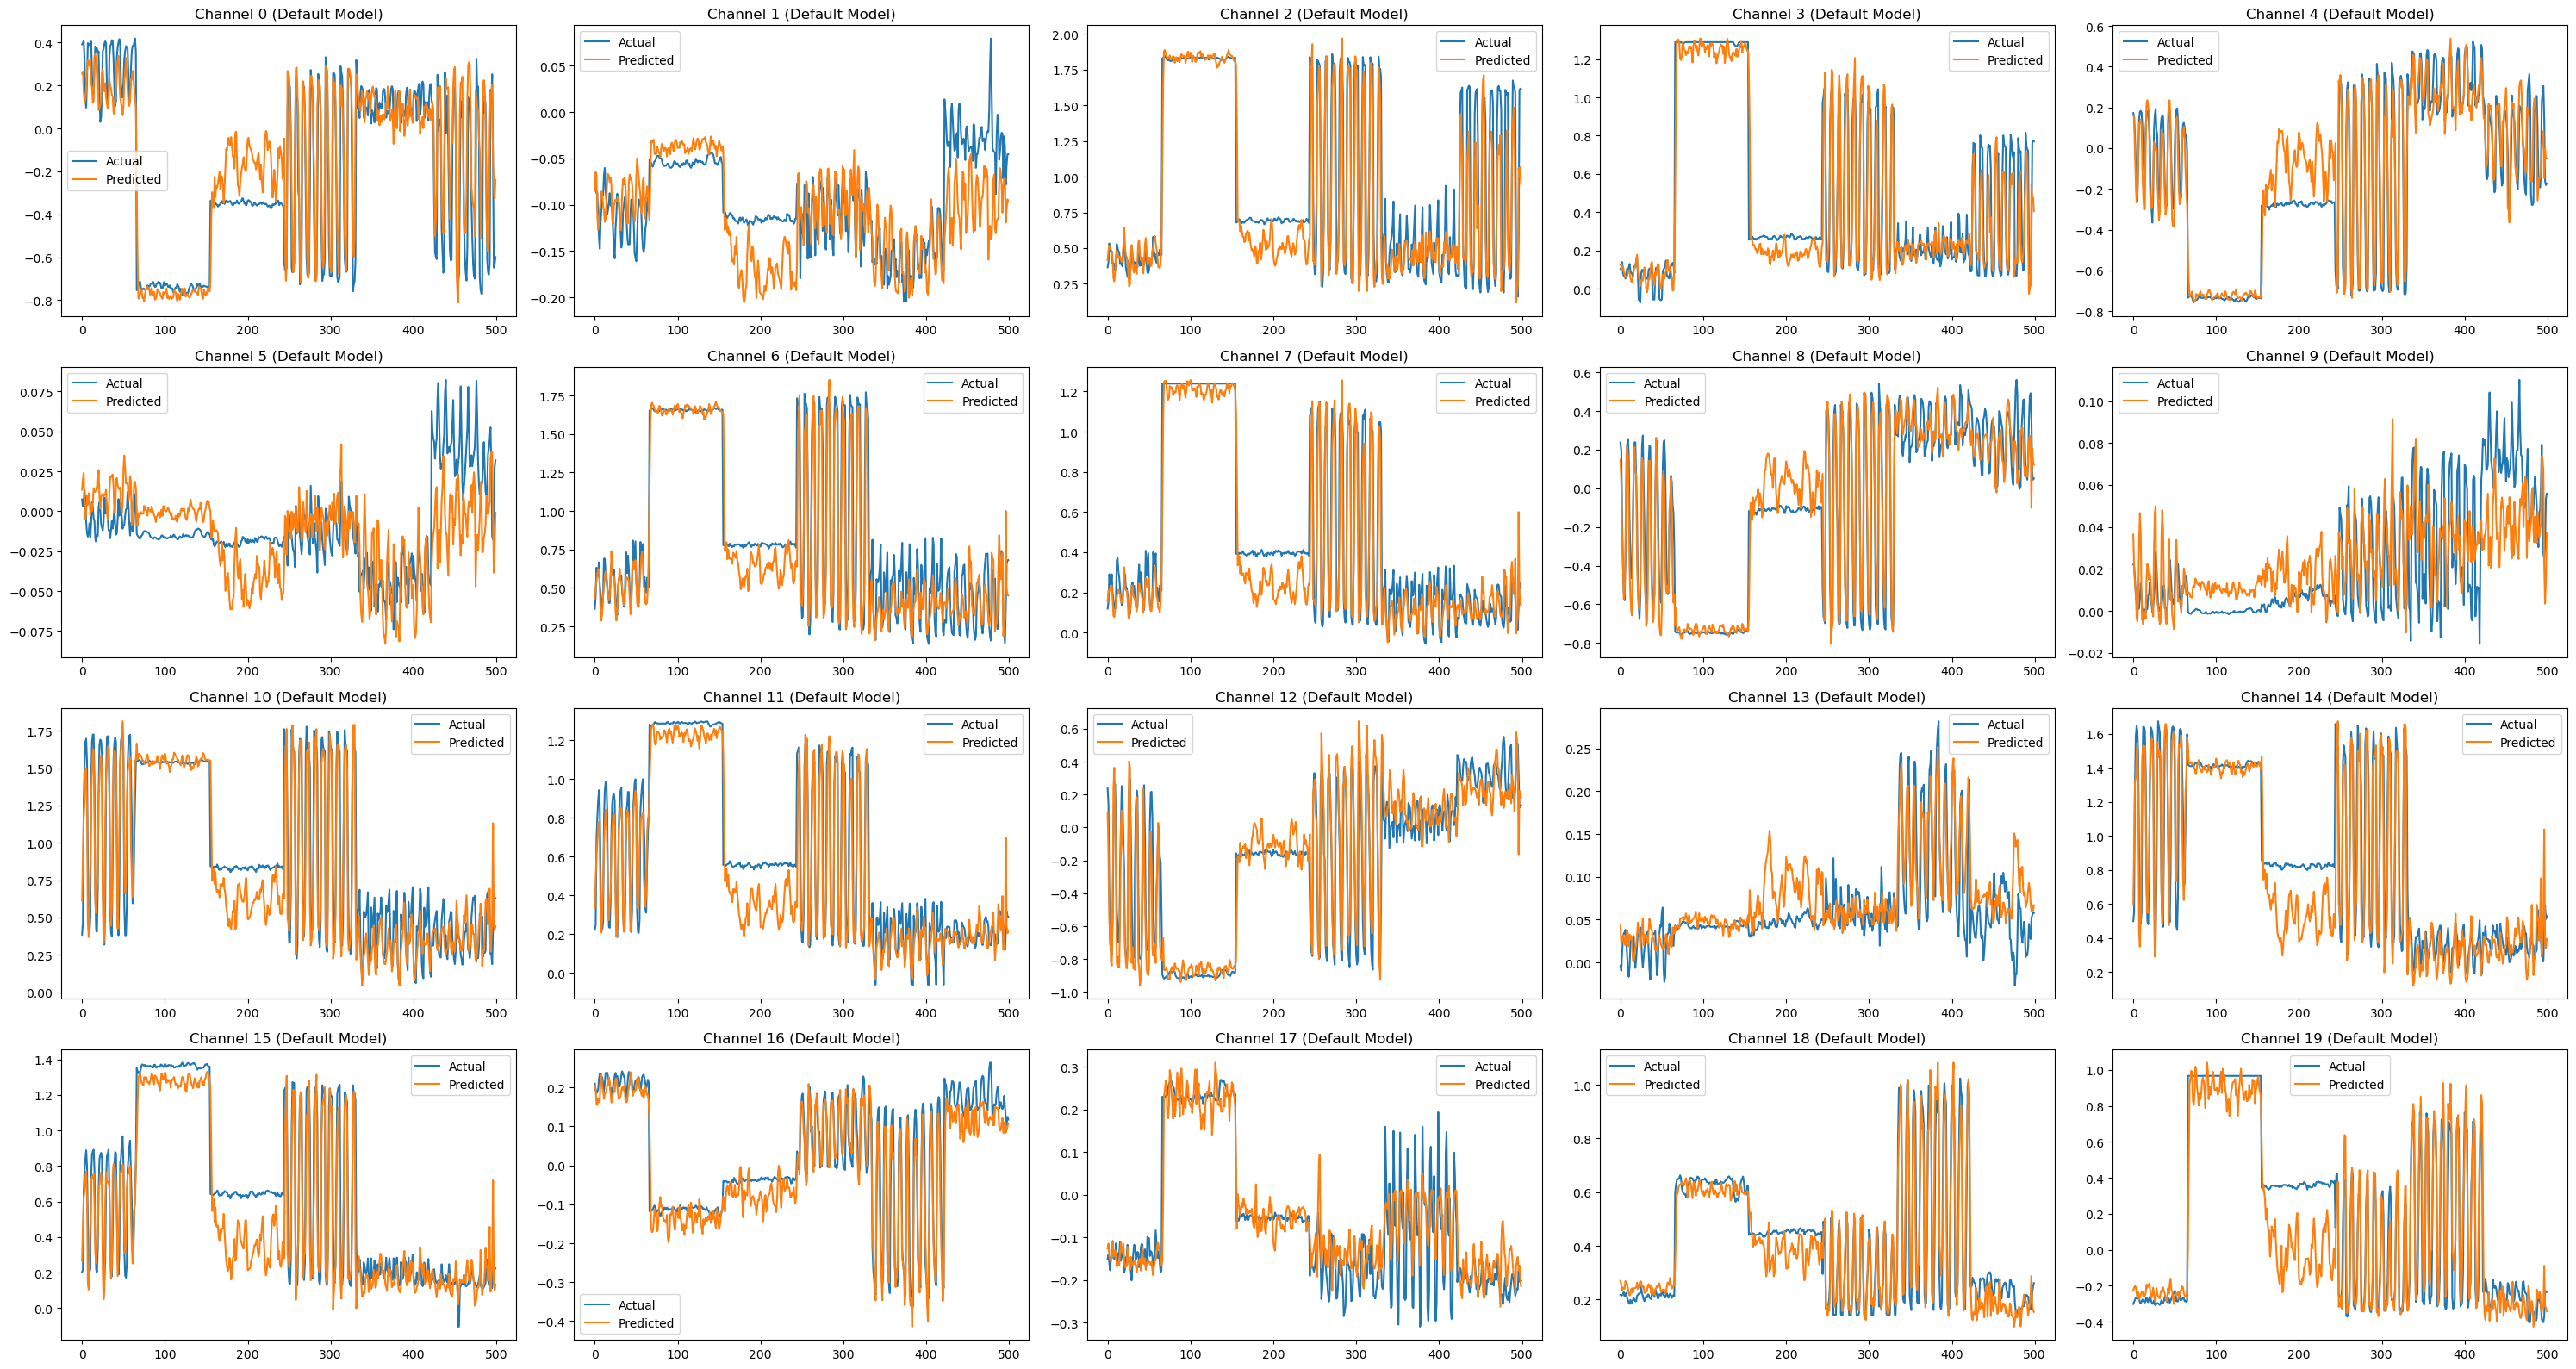

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[2600:3100, i])
    axs[i].plot(y_model_pred[2600:3100, i])
    axs[i].set_title(f"Channel {i} (Default Model)")
    axs[i].legend(["Actual", "Predicted"])

plt.tight_layout()
plt.show()

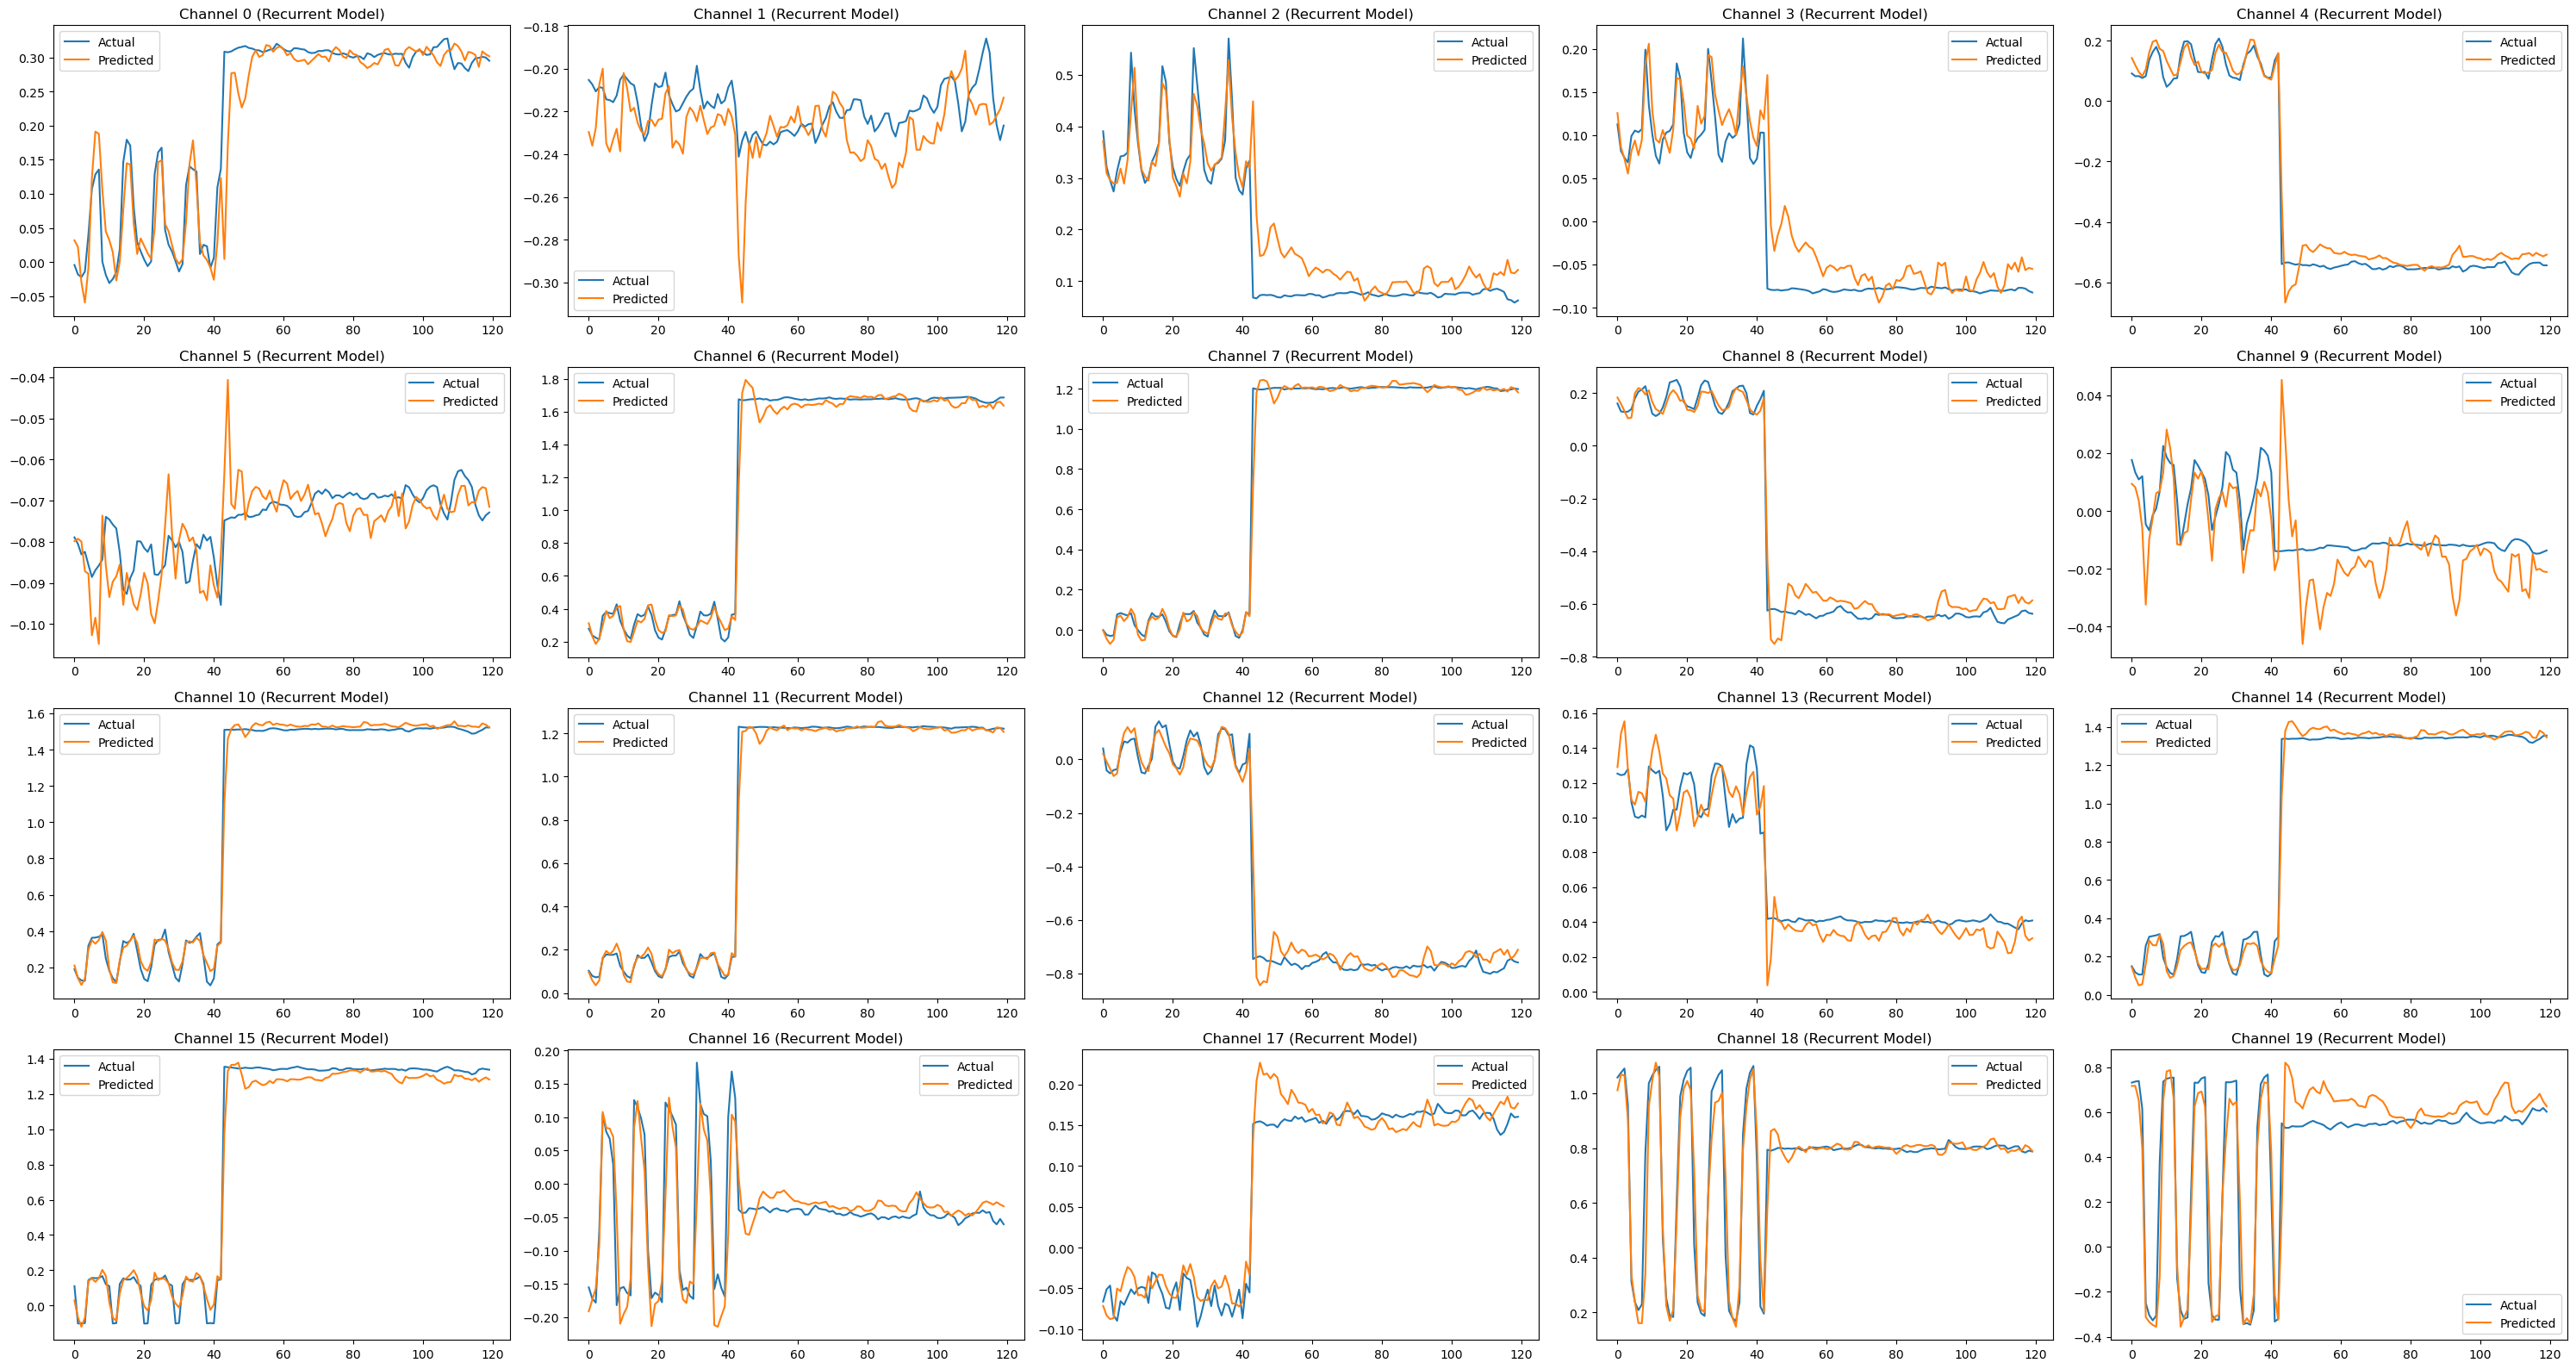

#### Autoregression model

In [ ]:
class EMGDecoderLSTM(nn.Module):
    def __init__(
        self, feat_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.2
    ):
        super().__init__()
        self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
        self.inp_dropout = nn.Dropout(dropout)

        self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
        self.hidden_dropout = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def forward_step(
        self,
        features: torch.Tensor,
        prev_output: torch.Tensor,
        hidden: torch.Tensor = None,
        cell: torch.Tensor = None,
    ):
        batch_size, device = features.size(0), features.device

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_dim, device=device)
        if cell is None:
            cell = torch.zeros(batch_size, self.hidden_dim, device=device)

        # 1) входной линейный слой + dropout
        inp = torch.cat([features, prev_output], dim=1)
        inp = self.inp_dropout(self.linear(inp))

        # 2) LSTMCell
        new_hidden, new_cell = self.lstm_cell(inp, (hidden, cell))

        # 3) dropout на скрытом состоянии
        h = self.hidden_dropout(new_hidden)

        # 4) выводной MLP
        pred = self.mlp(h)
        return pred, new_hidden, new_cell


class RiemannLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator: str = "oas",
        metric: str = "riemann",
        hidden_dim: int = 64,
        seq_len: int = 20,
        lr: float = 1e-3,
        alpha: float = 1e-5,
        max_iter: int = 50,
        batch_size: int = 32,
        device: str = "cpu",
        verbose: bool = False,
        save_best: bool = True,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lr = lr
        self.alpha = alpha
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.save_best = save_best

        # будут инициализированы в fit
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(
        self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None, load_checkpoint=None
    ):
        # X: (n_windows, n_ch, n_time), y: (n_windows, 20)
        # 1) Riemann-признаки
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)  # (T, feat_dim)

        # 2) Переход к numpy, чтобы сформировать sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        # X_seq: (n_seq, seq_len, feat); y_seq: (n_seq, seq_len, 20)

        # 3) В даталоадер подаём X_seq и y_seq
        # Сшиваем по последнему измерению: для каждой позиции t обучаем модель последовательно
        # но DataLoader вернёт полный seq.
        dataset = TensorDataset(
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_seq, dtype=torch.float32),
        )
        loader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

        # 4) Создаём модель
        feat_dim = X_ts.shape[1]
        output_dim = y.shape[1]
        self.model_ = EMGDecoderLSTM(feat_dim, self.hidden_dim, output_dim).to(
            self.device
        )

        if load_checkpoint is not None:
            self.model_.load_state_dict(
                torch.load(load_checkpoint, map_location=self.device)
            )
            print(f"Checkpoint loaded from {load_checkpoint}")

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=self.max_iter // 2, gamma=0.7
        )

        best_val_loss = float("inf")
        best_model_state = None

        # 5) Тренировочный цикл с teacher forcing
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0.0
            for Xb, yb in loader:
                # Xb: (B, seq_len, feat), yb: (B, seq_len, out)
                Xb = Xb.to(self.device)
                yb = yb.to(self.device)
                batch_size = Xb.size(0)

                prev_pred = torch.zeros(batch_size, output_dim, device=self.device)
                hidden = None
                cell = None
                loss_batch = 0.0

                for t in range(self.seq_len):
                    feat_t = Xb[:, t, :]
                    target_t = yb[:, t, :]
                    pred_t, hidden, cell = self.model_.forward_step(
                        feat_t, prev_pred, hidden, cell
                    )
                    loss_batch += criterion(pred_t, target_t)
                    # teacher forcing
                    prev_pred = target_t.detach()

                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                epoch_loss += loss_batch.item()

            scheduler.step()

            if self.verbose and epoch % 1 == 0:
                # --- Тренировочные метрики ---
                train_preds = self.predict(X)
                mse_train = np.mean((train_preds - y) ** 2)
                corrs = [
                    np.corrcoef(train_preds[:, i], y[:, i])[0, 1]
                    for i in range(y.shape[1])
                ]
                mean_corr = np.nanmean(corrs)
                r2 = r2_score(y, train_preds)

                msg = (
                    f"Epoch {epoch}/{self.max_iter} | "
                    f"AvgBatchLoss: {epoch_loss/len(loader):.4f} | "
                    f"Train MSE: {mse_train:.4f}, Corr: {mean_corr:.3f}, R2: {r2:.3f}"
                )

                # --- Валидационные метрики (если есть) ---
                if X_val is not None and y_val is not None:
                    val_preds = self.predict(X_val)
                    mse_val = np.mean((val_preds - y_val) ** 2)
                    corrs_val = [
                        np.corrcoef(val_preds[:, i], y_val[:, i])[0, 1]
                        for i in range(y_val.shape[1])
                    ]
                    mean_corr_val = np.nanmean(corrs_val)
                    r2_val = r2_score(y_val, val_preds)
                    msg += (
                        f" | Val MSE: {mse_val:.4f}, Corr: {mean_corr_val:.3f}, "
                        f"R2: {r2_val:.3f}"
                    )

                    # --- Сохраняем лучшую модель
                    if mse_val < best_val_loss:
                        best_val_loss = mse_val
                        best_model_state = copy.deepcopy(self.model_.state_dict())

                print(msg)

        if best_model_state is not None and self.save_best:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Блочное предсказание (batch of windows), но без teacher forcing:
        # 1) ковариации → ts
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)  # (T, feat_dim)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

        self.model_.eval()
        preds = []
        prev_pred = torch.zeros(1, self.model_.output_dim, device=self.device)
        hidden = None
        cell = None

        with torch.no_grad():
            for feat in X_ts:
                feat = feat.unsqueeze(0)  # (1, feat_dim)
                pred_t, hidden, cell = self.model_.forward_step(
                    feat, prev_pred, hidden, cell
                )
                preds.append(pred_t.cpu().numpy().ravel())
                prev_pred = pred_t

        return np.vstack(preds)  # (T, output_dim)

    def save_model(self, path: str) -> None:
        """
        Сохраняет только веса модели в файл.
        """
        torch.save(self.model_.state_dict(), path)

#### Fedor. Autoregression

In [ ]:
# ---------------- SEQUENCE PREPARATION ----------------


def prepare_sequences(X, y, seq_len):
    n_samples, feat_dim = X.shape
    _, out_dim = y.shape
    n_seq = n_samples - seq_len
    X_seq = np.zeros((n_seq, seq_len, feat_dim), dtype=X.dtype)
    y_seq = np.zeros((n_seq, seq_len, out_dim), dtype=y.dtype)
    for i in range(n_seq):
        X_seq[i] = X[i : i + seq_len]
        y_seq[i] = y[i : i + seq_len]
    return X_seq, y_seq


def prepare_single_sequence(X, seq_len):
    n_samples, feat_dim = X.shape
    if n_samples < seq_len:
        pad = np.zeros((seq_len - n_samples, feat_dim), dtype=X.dtype)
        seq = np.vstack([pad, X])
    else:
        seq = X[-seq_len:]
    return seq[np.newaxis, ...]


def corrcoef_flat(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def validation(model, X_test, y_test, verbose=True):
    y_pred = []
    for i in range(len(X_test)):
        # берем все окна до i-го включительно,
        # чтобы модель имела предыдущие seq_len шагов
        # (prepare_single_sequence внутри predict сама допадит нулями, если данных < seq_len).
        input_seq = X_test[: i + 1]
        # print("input_seq shape:", input_seq.shape)
        # model.predict возвращает массив формы (1, seq_len, out_dim)
        seq_pred = model.predict(input_seq)
        # берем последний шаг предсказанной последовательности
        y_t = seq_pred[0, -1, :]  # (out_dim,)
        y_pred.append(y_t)

    y_pred = np.stack(y_pred, axis=0)  # (177, 20)

    # считаем корреляцию по каждому из 20 каналов
    corrs = []
    r2s = []
    for chan in range(y_test.shape[1]):
        y_true_chan = y_test[:, chan]
        y_pred_chan = y_pred[:, chan]

        # Pearson correlation
        c = corrcoef_flat(y_pred_chan, y_true_chan)
        corrs.append(c)

        # R2 score
        # если все значения y_true одинаковы, r2_score вернёт ValueError,
        # можно в этом случае руками положить 0.0
        if np.allclose(y_true_chan, y_true_chan[0]):
            r2 = 0.0
        else:
            r2 = r2_score(y_true_chan, y_pred_chan)
        r2s.append(r2)

    mean_corr = np.nanmean(corrs)
    mean_r2 = np.nanmean(r2s)

    # вывод результатов
    results = {}
    results["model"] = {
        "all_correlations": corrs,
        "mean_correlation": np.nanmean(corrs),
        "std_correlation": np.nanstd(corrs),
        "all_r2": r2s,
        "mean_r2": np.nanmean(r2s),
        "std_r2": np.nanstd(r2s),
    }

    if verbose:
        print("Channel-wise correlations:", [f"{c:.3f}" for c in corrs])
        print("Mean correlation:        ", f"{mean_corr:.3f}")
        print("Channel-wise R2 scores:  ", [f"{r:.3f}" for r in r2s])
        print("Mean R2 score:           ", f"{mean_r2:.3f}")

        for name, metrics in results.items():
            print(f"{name}:")
            print(
                f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
            )
            print(
                f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
            )
            print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
            print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')
    else:
        print(
            f'  Mean correlation: {results["model"]["mean_correlation"]:.3f} ± {results["model"]["std_correlation"]:.3f}'
        )
        print(
            f'  Mean R2: {results["model"]["mean_r2"]:.3f} ± {results["model"]["std_r2"]:.3f}'
        )
    return y_pred

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchAutoRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_dim + output_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_seq, y_prev=None, teacher_forcing=False):
        batch, seq_len, _ = x_seq.shape
        device = x_seq.device
        outputs = []
        h, c = None, None
        y_t = torch.zeros(batch, self.output_dim, device=device)
        for t in range(seq_len):
            x_t = x_seq[:, t]
            inp = torch.cat([x_t, y_t], dim=-1).unsqueeze(1)
            out_lstm, (h, c) = self.lstm(inp, (h, c) if h is not None else None)
            y_pred = self.mlp(out_lstm[:, 0])
            outputs.append(y_pred.unsqueeze(1))
            y_t = y_prev[:, t] if (teacher_forcing and y_prev is not None) else y_pred
        return torch.cat(outputs, dim=1)


class RiemannAutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_dim=128,
        seq_len=10,
        num_layers=1,
        alpha=1e-5,
        lr=1e-3,
        max_iter=1,
        batch_size=32,
        device="cpu",
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y, X_val=None, y_val=None):
        # 1) Riemannian features
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        # Validation transforms
        if X_val is not None and y_val is not None:
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)

        # 2) Autoregressive sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        if X_val is not None and y_val is not None:
            X_seq_val, y_seq_val = prepare_sequences(X_ts_val, y_val, self.seq_len)

        # to tensors
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        y_seq = torch.tensor(y_seq, dtype=torch.float32).to(self.device)
        if X_val is not None and y_val is not None:
            X_seq_val = torch.tensor(X_seq_val, dtype=torch.float32).to(self.device)
            y_seq_val = torch.tensor(y_seq_val, dtype=torch.float32).to(self.device)

        print(X_seq_val.shape)
        print(y_seq_val.shape)

        # dims
        _, seq_len, feat_dim = X_seq.shape
        _, _, out_dim = y_seq.shape

        # 3) Model init
        self.model_ = TorchAutoRegressor(
            input_dim=feat_dim,
            hidden_dim=self.hidden_dim,
            output_dim=out_dim,
            num_layers=self.num_layers,
        ).to(self.device)
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)
        criterion = nn.MSELoss()
        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_seq, y_seq),
            batch_size=self.batch_size,
            shuffle=True,
        )

        # Training loop
        for epoch in range(1, self.max_iter + 1):

            # train
            self.model_.train()
            total_loss = 0.0

            for xb, yb in loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                out = self.model_(xb, y_prev=yb, teacher_forcing=True)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            # metrics
            if self.verbose and epoch % 10 == 0:
                avg_train_loss = total_loss / len(loader)

                # train corr
                self.model_.eval()
                with torch.no_grad():
                    pred_train = self.model_(X_seq, teacher_forcing=False).cpu().numpy()
                y_train_np = y_seq.cpu().numpy()
                train_corrs = [
                    corrcoef(pred_train[:, :, i].ravel(), y_train_np[:, :, i].ravel())
                    for i in range(out_dim)
                ]
                train_mean_corr = np.nanmean(train_corrs)
                msg = f"Epoch {epoch}/{self.max_iter} Train Loss: {avg_train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                # val metrics
                if X_val is not None and y_val is not None:
                    with torch.no_grad():
                        pred_val = (
                            self.model_(X_seq_val, teacher_forcing=False).cpu().numpy()
                        )
                    y_val_np = y_seq_val.cpu().numpy()
                    val_loss = criterion(
                        torch.tensor(pred_val), torch.tensor(y_val_np)
                    ).item()
                    val_corrs = [
                        corrcoef(pred_val[:, :, i].ravel(), y_val_np[:, :, i].ravel())
                        for i in range(out_dim)
                    ]
                    val_mean_corr = np.nanmean(val_corrs)
                    msg += f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                print(msg)

                # validation
                # if self.verbose:
                #     validation(self, X_val, y_val, verbose=False)

        return self

    def validate(self, X, y):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq = prepare_single_sequence(X_ts, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()


model = RiemannAutoRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=10,
    num_layers=1,
    alpha=1e-5,
    lr=1e-3,
    max_iter=50,
    batch_size=64,
    device="cuda",
    verbose=True,
)
model.fit(X_train, y_train, X_test, y_test)

torch.Size([345, 10, 21])
torch.Size([345, 10, 20])
Epoch 10/50 Train Loss: 0.0100, Train Corr: 0.935, Val Loss: 0.0155, Val Corr: 0.917
Epoch 20/50 Train Loss: 0.0063, Train Corr: 0.955, Val Loss: 0.0143, Val Corr: 0.934
Epoch 30/50 Train Loss: 0.0046, Train Corr: 0.964, Val Loss: 0.0121, Val Corr: 0.943
Epoch 40/50 Train Loss: 0.0039, Train Corr: 0.967, Val Loss: 0.0127, Val Corr: 0.943
Epoch 50/50 Train Loss: 0.0035, Train Corr: 0.970, Val Loss: 0.0117, Val Corr: 0.946


RiemannAutoRegressor(batch_size=64, device='cuda', max_iter=50, verbose=True)

In [6]:
y_pred = validation(model, X_test, y_test, verbose=True)

100%|██████████| 355/355 [00:12<00:00, 27.99it/s]

Channel-wise correlations: ['0.943', '0.852', '0.955', '0.959', '0.953', '0.857', '0.955', '0.957', '0.953', '0.939', '0.956', '0.956', '0.950', '0.922', '0.956', '0.963', '0.948', '0.966', '0.949', '0.944']
Mean correlation:         0.942
Channel-wise R2 scores:   ['0.889', '0.650', '0.908', '0.916', '0.906', '0.727', '0.906', '0.911', '0.906', '0.844', '0.906', '0.909', '0.898', '0.843', '0.907', '0.924', '0.894', '0.930', '0.896', '0.890']
Mean R2 score:            0.878
model:
  Mean correlation: 0.942 ± 0.031
  Individual correlations: ['0.943', '0.852', '0.955', '0.959', '0.953', '0.857', '0.955', '0.957', '0.953', '0.939', '0.956', '0.956', '0.950', '0.922', '0.956', '0.963', '0.948', '0.966', '0.949', '0.944']

  Mean R2: 0.878 ± 0.068
  Individual R2: ['0.889', '0.650', '0.908', '0.916', '0.906', '0.727', '0.906', '0.911', '0.906', '0.844', '0.906', '0.909', '0.898', '0.843', '0.907', '0.924', '0.894', '0.930', '0.896', '0.890']



In [8]:
y_pred = validation_streaming(model, X_test, y_test, verbose=True)

Channel-wise correlations: ['0.936', '0.845', '0.954', '0.959', '0.950', '0.866', '0.949', '0.952', '0.950', '0.937', '0.949', '0.949', '0.945', '0.923', '0.952', '0.957', '0.946', '0.966', '0.945', '0.940']
Mean correlation:         0.939
Channel-wise R2 scores:   ['0.873', '0.620', '0.903', '0.913', '0.897', '0.740', '0.887', '0.895', '0.896', '0.836', '0.887', '0.890', '0.886', '0.848', '0.890', '0.907', '0.890', '0.931', '0.886', '0.880']
Mean R2 score:            0.868
model:
  Mean correlation: 0.939 ± 0.029
  Individual correlations: ['0.936', '0.845', '0.954', '0.959', '0.950', '0.866', '0.949', '0.952', '0.950', '0.937', '0.949', '0.949', '0.945', '0.923', '0.952', '0.957', '0.946', '0.966', '0.945', '0.940']

  Mean R2: 0.868 ± 0.068
  Individual R2: ['0.873', '0.620', '0.903', '0.913', '0.897', '0.740', '0.887', '0.895', '0.896', '0.836', '0.887', '0.890', '0.886', '0.848', '0.890', '0.907', '0.890', '0.931', '0.886', '0.880']



In [ ]:
# 1) Riemann-признаки
X_cov = model.cov_.transform(X_test)
X_ts = model.ts_.transform(X_cov)

# 2) Приводим к torch.Tensor формы (1, N, feat_dim)
device = next(model.model_.parameters()).device
X_full = torch.tensor(X_ts, dtype=torch.float32, device=device).unsqueeze(
    0
)  # (1, N, F)

# 3) Прогон через модель один раз, без teacher_forcing
model.model_.eval()
with torch.no_grad():
    out_full = model.model_(X_full, teacher_forcing=False)
    # out_full.shape == (1, N, out_dim)

# 4) Получаем N×out_dim
y_pred_all = out_full[0].cpu().numpy()  # (N, out_dim)

Traceback (most recent call last):
  File "c:\Users\laput\miniconda3\envs\pcb\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 478, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'tensor' is not defined


: 

In [14]:
X_cov.shape, X_ts.shape, device, X_full.shape

((355, 6, 6),
 (355, 21),
 device(type='cuda', index=0),
 torch.Size([1, 355, 21]))

In [19]:
y_pred = []
for i in range(len(X_test)):
    input_seq = X_test[: i + 1]
    seq_pred = model.predict(input_seq)
    y_t = seq_pred[0, -1, :]
    y_pred.append(y_t)

y_pred = np.stack(y_pred, axis=0)

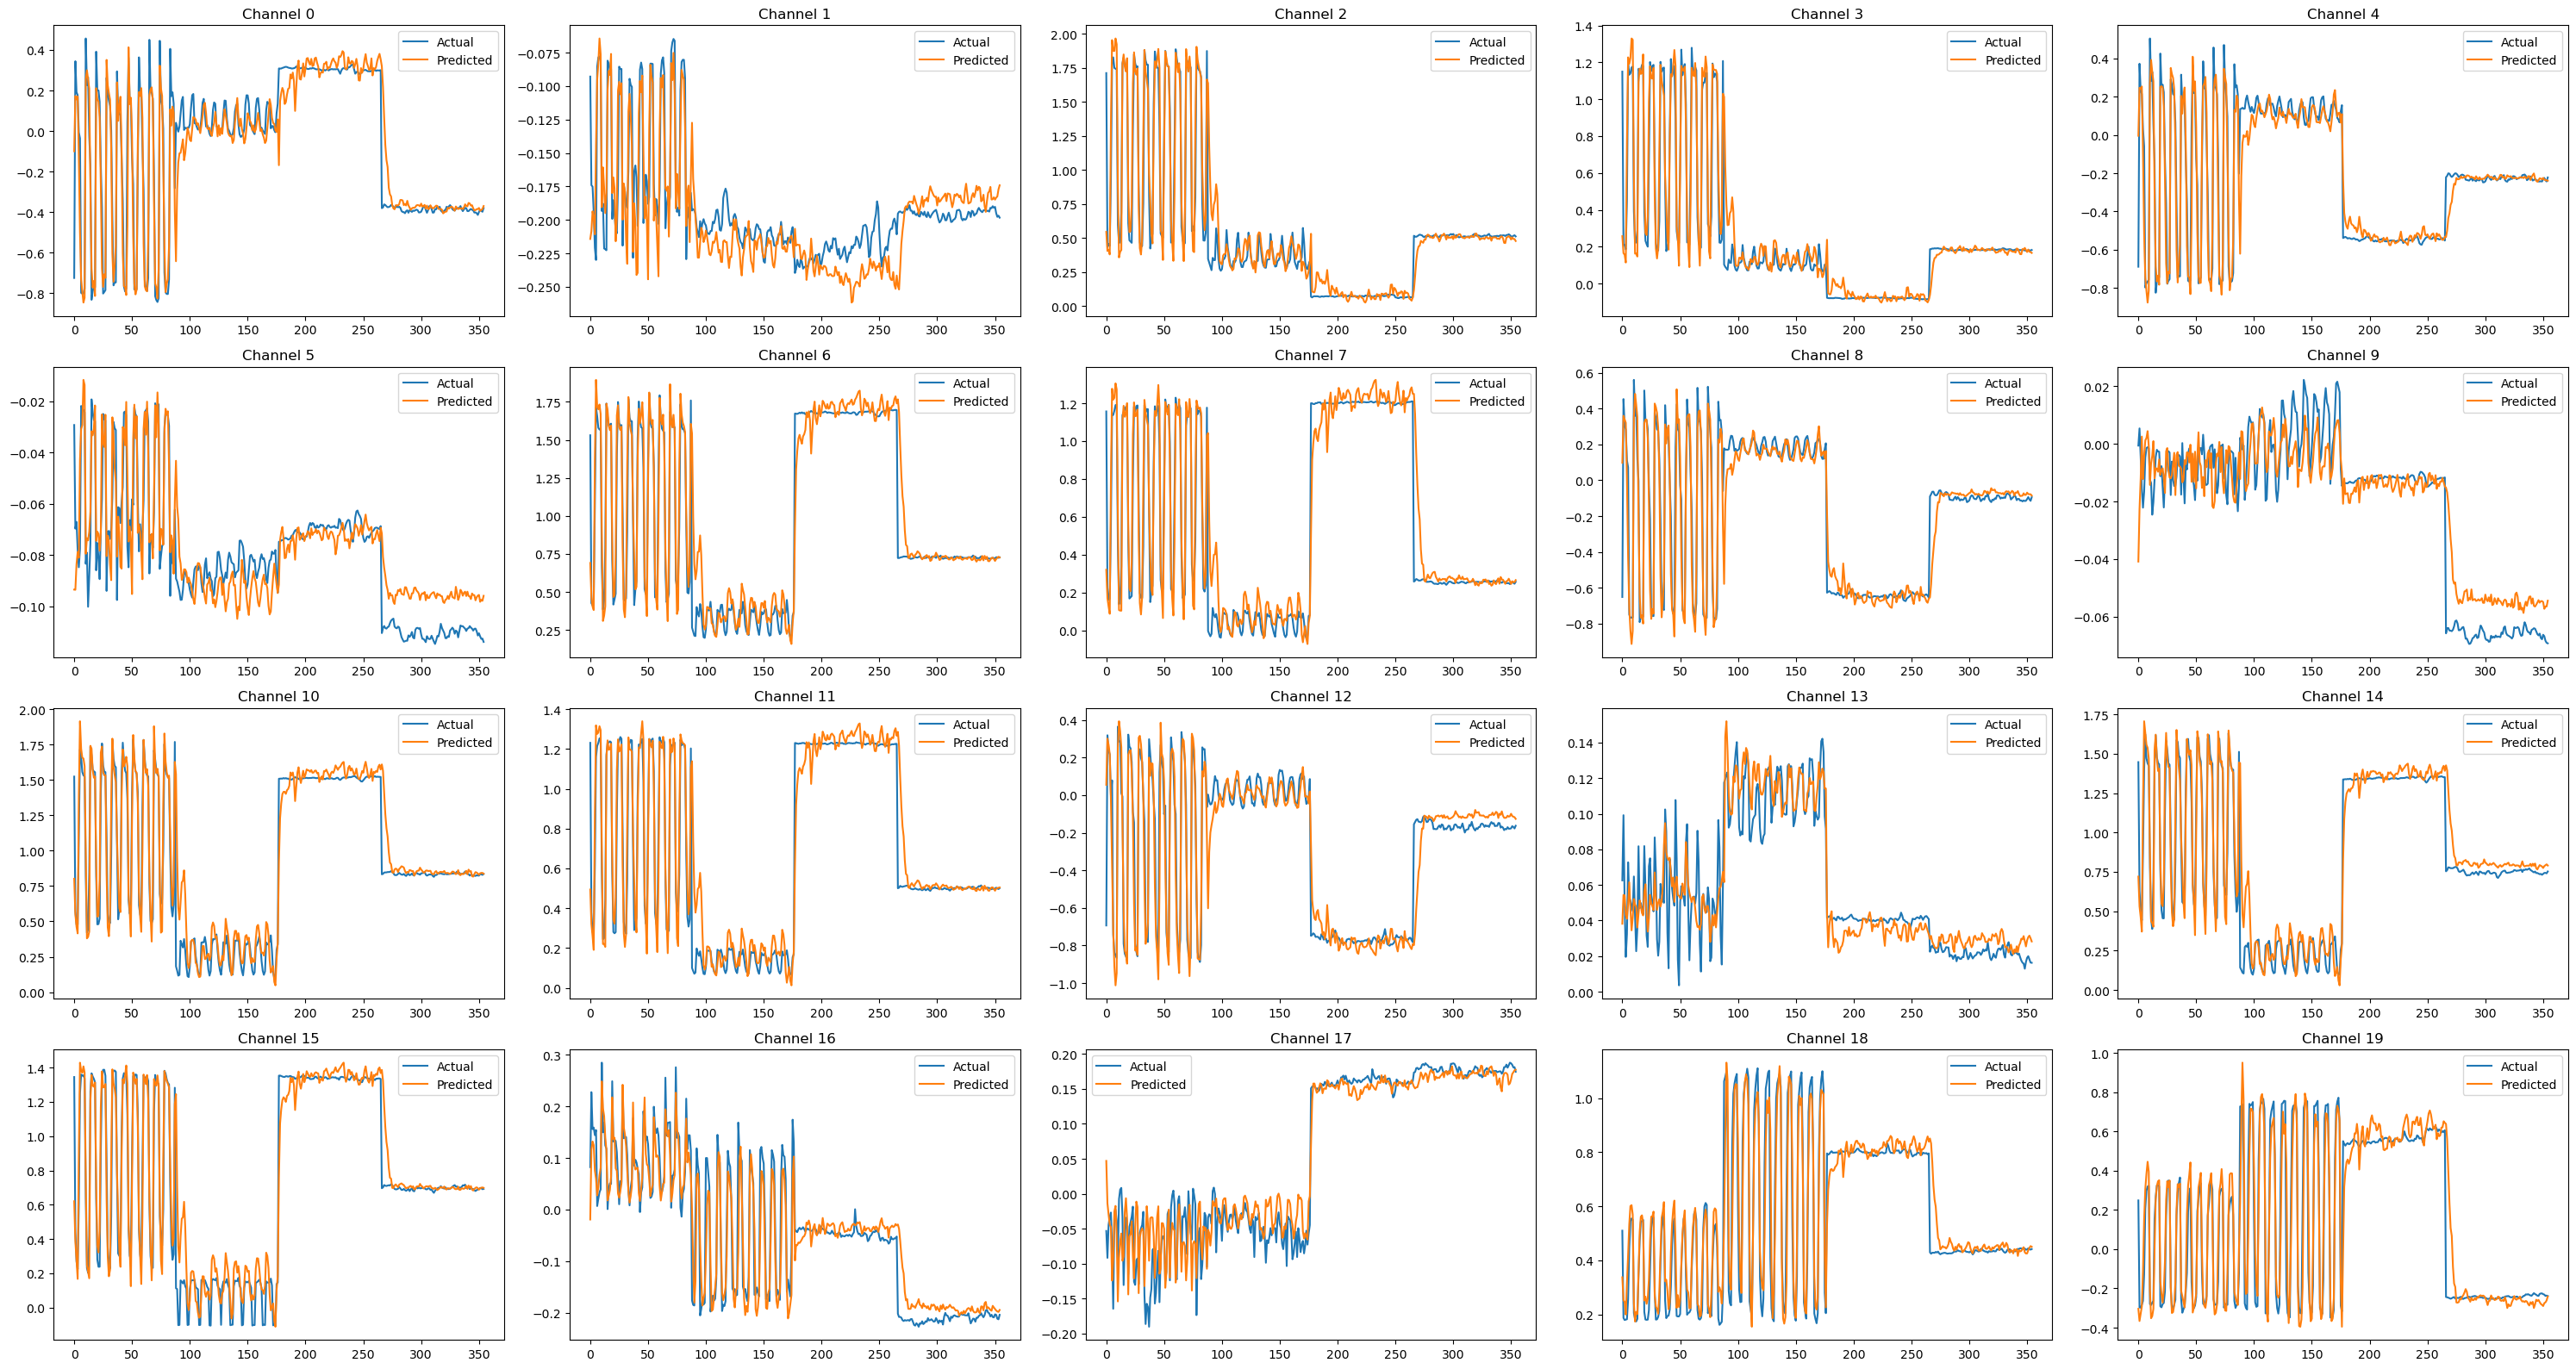

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[:, i])
    axs[i].plot(y_pred[:, i])
    axs[i].set_title(f"Channel {i}")
    axs[i].legend(["Actual", "Predicted"])

plt.tight_layout()
plt.show()

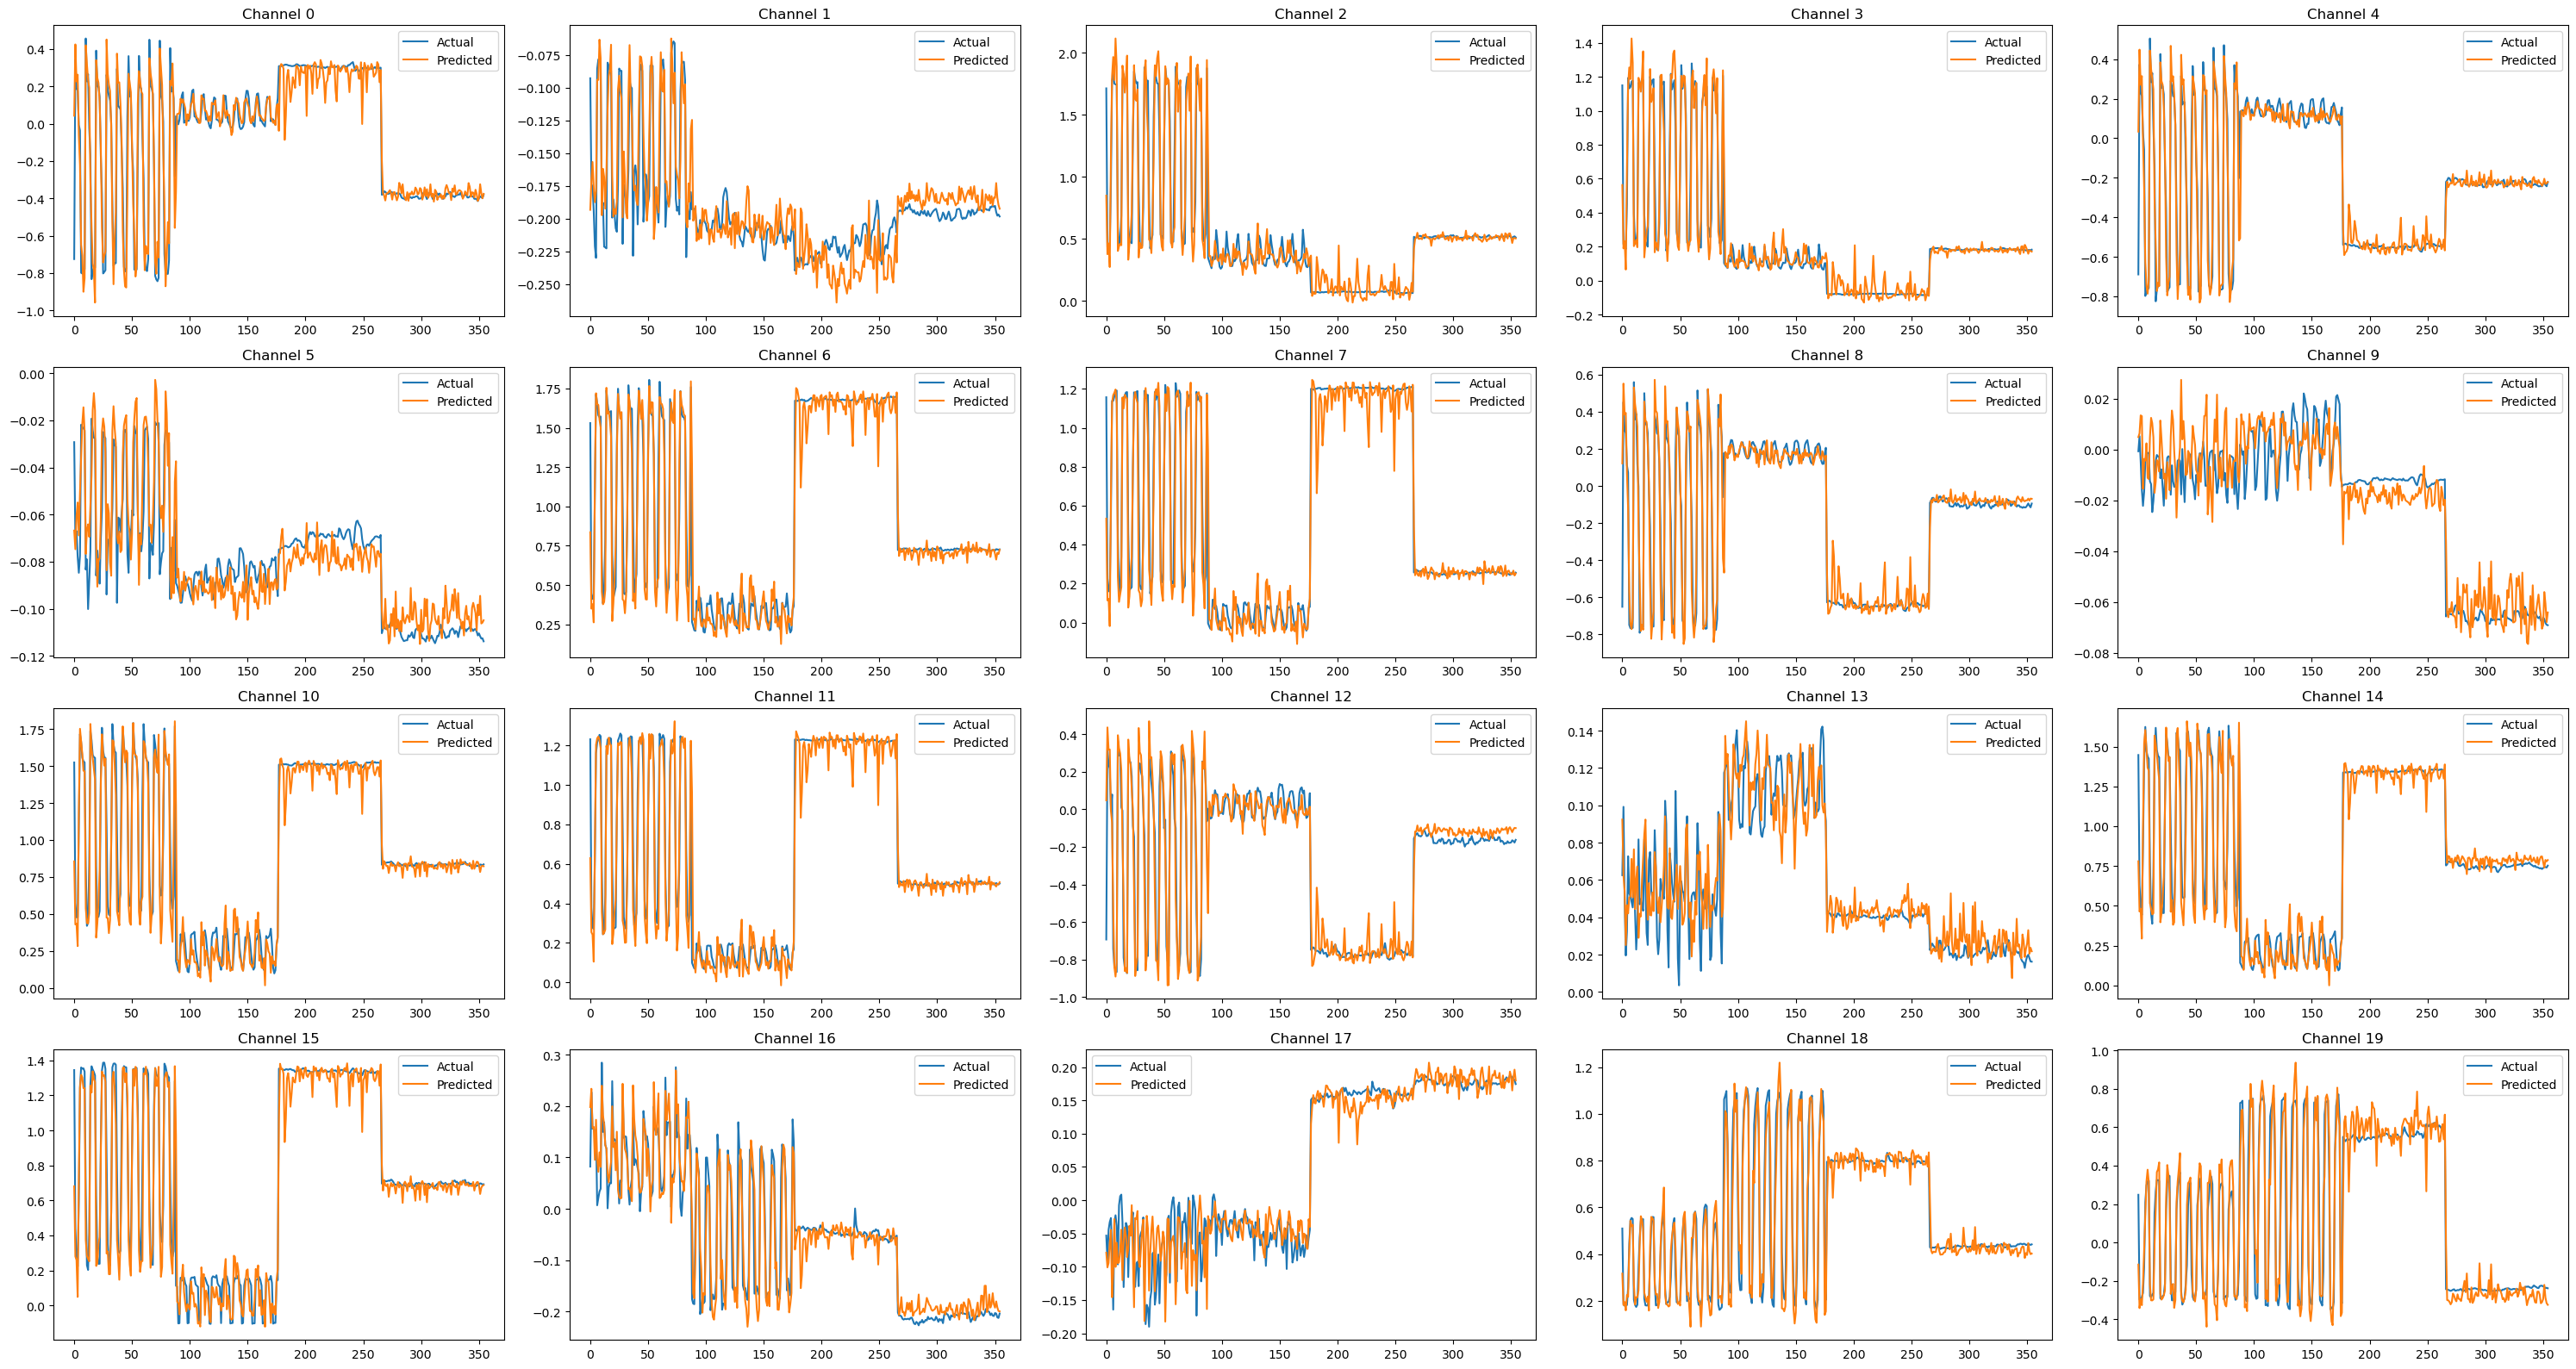

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[:, i])
    axs[i].plot(y_model_pred[:, i])
    axs[i].set_title(f"Channel {i}")
    axs[i].legend(["Actual", "Predicted"])

plt.tight_layout()
plt.show()

### Fedor January

In [10]:
# subj_path = "..\\data\\Fedor_Jan\\legacy\\Preprocessed\\Simple2\\5\\"
subj_path = "..\\data\\Fedor_Jan\\Preprocessed\\"
files = os.listdir(subj_path)
n_files = len(files)
n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for file in files:

    # arr = np.load(subj_path + "000" + str(i) + ".npz")
    # arr = np.load(subj_path + "Simple1_1_000" + str(i) + ".npz")
    arr = np.load(subj_path + file)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27743, 8, 128), (6935, 8, 128), (27743, 20), (6935, 20))

In [5]:
############################################
# 2) Пример запуска — выбор данных на
# обучение и валидацию вручную
############################################

# Параметры
subj_path = "../data/Fedor_Jan/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 250

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []
# test_files_subnames = ["Simple2_4"]
# train_files_subnames = ["Simple2_1", "Simple2_2", "Simple2_3", "Simple2_5"]
test_files_subnames = ["Simple2_4"]
train_files_subnames = ["Simple2_1", "Simple2_2", "Simple2_3"]


for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (10670, 8, 128) → (10670, 20)
Test  windows: (3555, 8, 128) → (3555, 20)


Default model

In [6]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


class TorchMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layer_sizes: list,
        output_dim: int,
        activation: str = "gelu",
        dropout_rate: float = 0.2,
        use_bn: bool = True,
        residual_connections: bool = False,
        init_method: str = "he",
    ):
        super(TorchMLP, self).__init__()
        self.residual_connections = residual_connections

        # Выбор активации
        activation_dict = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "selu": nn.SELU,
            "leaky_relu": nn.LeakyReLU,
            "swish": nn.SiLU,
        }
        act_layer = activation_dict.get(activation.lower(), nn.GELU)

        layers = []
        current_dim = input_dim

        # Построение скрытых слоев
        for i, h in enumerate(hidden_layer_sizes):
            # Линейный слой
            layers.append(nn.Linear(current_dim, h))

            # Инициализация весов
            if init_method == "he":
                nn.init.kaiming_normal_(layers[-1].weight, nonlinearity="relu")
            elif init_method == "xavier":
                nn.init.xavier_normal_(layers[-1].weight)

            # Batch Normalization
            if use_bn:
                layers.append(nn.BatchNorm1d(h))

            # Активация
            layers.append(act_layer())

            # Dropout
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            # Обновление размерности
            current_dim = h

        # Выходной слой
        self.output_layer = nn.Linear(current_dim, output_dim)

        # Инициализация выходного слоя
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0)

        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and self.residual_connections:
                if x.shape[-1] == layer.out_features:
                    residual = x
                x = layer(x)
                if x.shape == residual.shape:
                    x += residual
                    residual = x
            else:
                x = layer(x)
        return self.output_layer(x)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
        device="cpu",
        batch_size=64,
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    # Изменённый метод fit принимает дополнительно X_val и y_val для вычисления тестового лосса и корреляции
    def fit(self, X, y, X_val=None, y_val=None):
        # Вычисление ковариаций и переход в тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        input_dim = X_ts.shape[1]
        output_dim = y_tensor.shape[1]

        self.model_ = TorchMLP(
            input_dim=input_dim,
            hidden_layer_sizes=self.hidden_layer_sizes,
            output_dim=output_dim,
            activation=self.activation,
            dropout_rate=0,
            use_bn=False,
            residual_connections=False,
            init_method="no",
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

        dataset = torch.utils.data.TensorDataset(X_ts, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        # Если заданы данные для валидации, подготовим их
        if (X_val is not None) and (y_val is not None):
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)
            X_ts_val = torch.tensor(X_ts_val, dtype=torch.float32).to(self.device)
            y_tensor_val = torch.tensor(y_val, dtype=torch.float32).to(self.device)

        # Обучение модели
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                output = self.model_(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()

            # Каждые 50 эпох (или можно менять условие) вычисляем и выводим метрики
            if self.verbose and ((epoch + 1) % 50 == 0):
                # Рассчёт метрик на тренировочных данных
                self.model_.eval()
                with torch.no_grad():
                    # Предсказания на тренинге
                    train_preds = self.model_(X_ts).cpu().numpy()
                    train_loss = criterion(self.model_(X_ts), y_tensor).item()

                    # Вычисление корреляции по каждому выходу
                    train_corrs = []
                    y_true_np = y_tensor.cpu().numpy()
                    for i in range(train_preds.shape[1]):
                        train_corrs.append(corrcoef(train_preds[:, i], y_true_np[:, i]))
                    train_mean_corr = np.nanmean(train_corrs)

                    metrics_str = f"Epoch {epoch+1}/{self.max_iter}: Train Loss: {train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                    # Если есть валидация – аналогичные расчёты
                    if (X_val is not None) and (y_val is not None):
                        val_preds = self.model_(X_ts_val).cpu().numpy()
                        val_loss = criterion(self.model_(X_ts_val), y_tensor_val).item()
                        val_corrs = []
                        y_val_np = y_tensor_val.cpu().numpy()
                        for i in range(val_preds.shape[1]):
                            val_corrs.append(corrcoef(val_preds[:, i], y_val_np[:, i]))
                        val_mean_corr = np.nanmean(val_corrs)
                        metrics_str += (
                            f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                        )

                    print(metrics_str)

        return self

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts).cpu().numpy()
        return preds


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(256, 256),
    activation="gelu",
    max_iter=100,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

model.fit(X_train, y_train, X_test, y_test)
y_model_pred = model.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corr
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
    print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')

X_cov.shape: (10670, 8, 8)
X_ts.shape: (10670, 36)
Epoch 50/100: Train Loss: 0.0083, Train Corr: 0.946, Val Loss: 0.0211, Val Corr: 0.821
Epoch 100/100: Train Loss: 0.0067, Train Corr: 0.952, Val Loss: 0.0217, Val Corr: 0.831
model:
  Mean correlation: 0.831 ± 0.160
  Individual correlations: ['0.922', '0.693', '0.937', '0.949', '0.927', '0.617', '0.934', '0.941', '0.933', '0.713', '0.932', '0.945', '0.914', '0.681', '0.916', '0.940', '0.861', '0.306', '0.795', '0.761']

  Mean R2: 0.602 ± 0.456
  Individual R2: ['0.838', '0.402', '0.861', '0.868', '0.858', '0.346', '0.858', '0.857', '0.869', '0.451', '0.857', '0.869', '0.833', '0.452', '0.833', '0.845', '0.693', '-1.136', '0.416', '0.170']



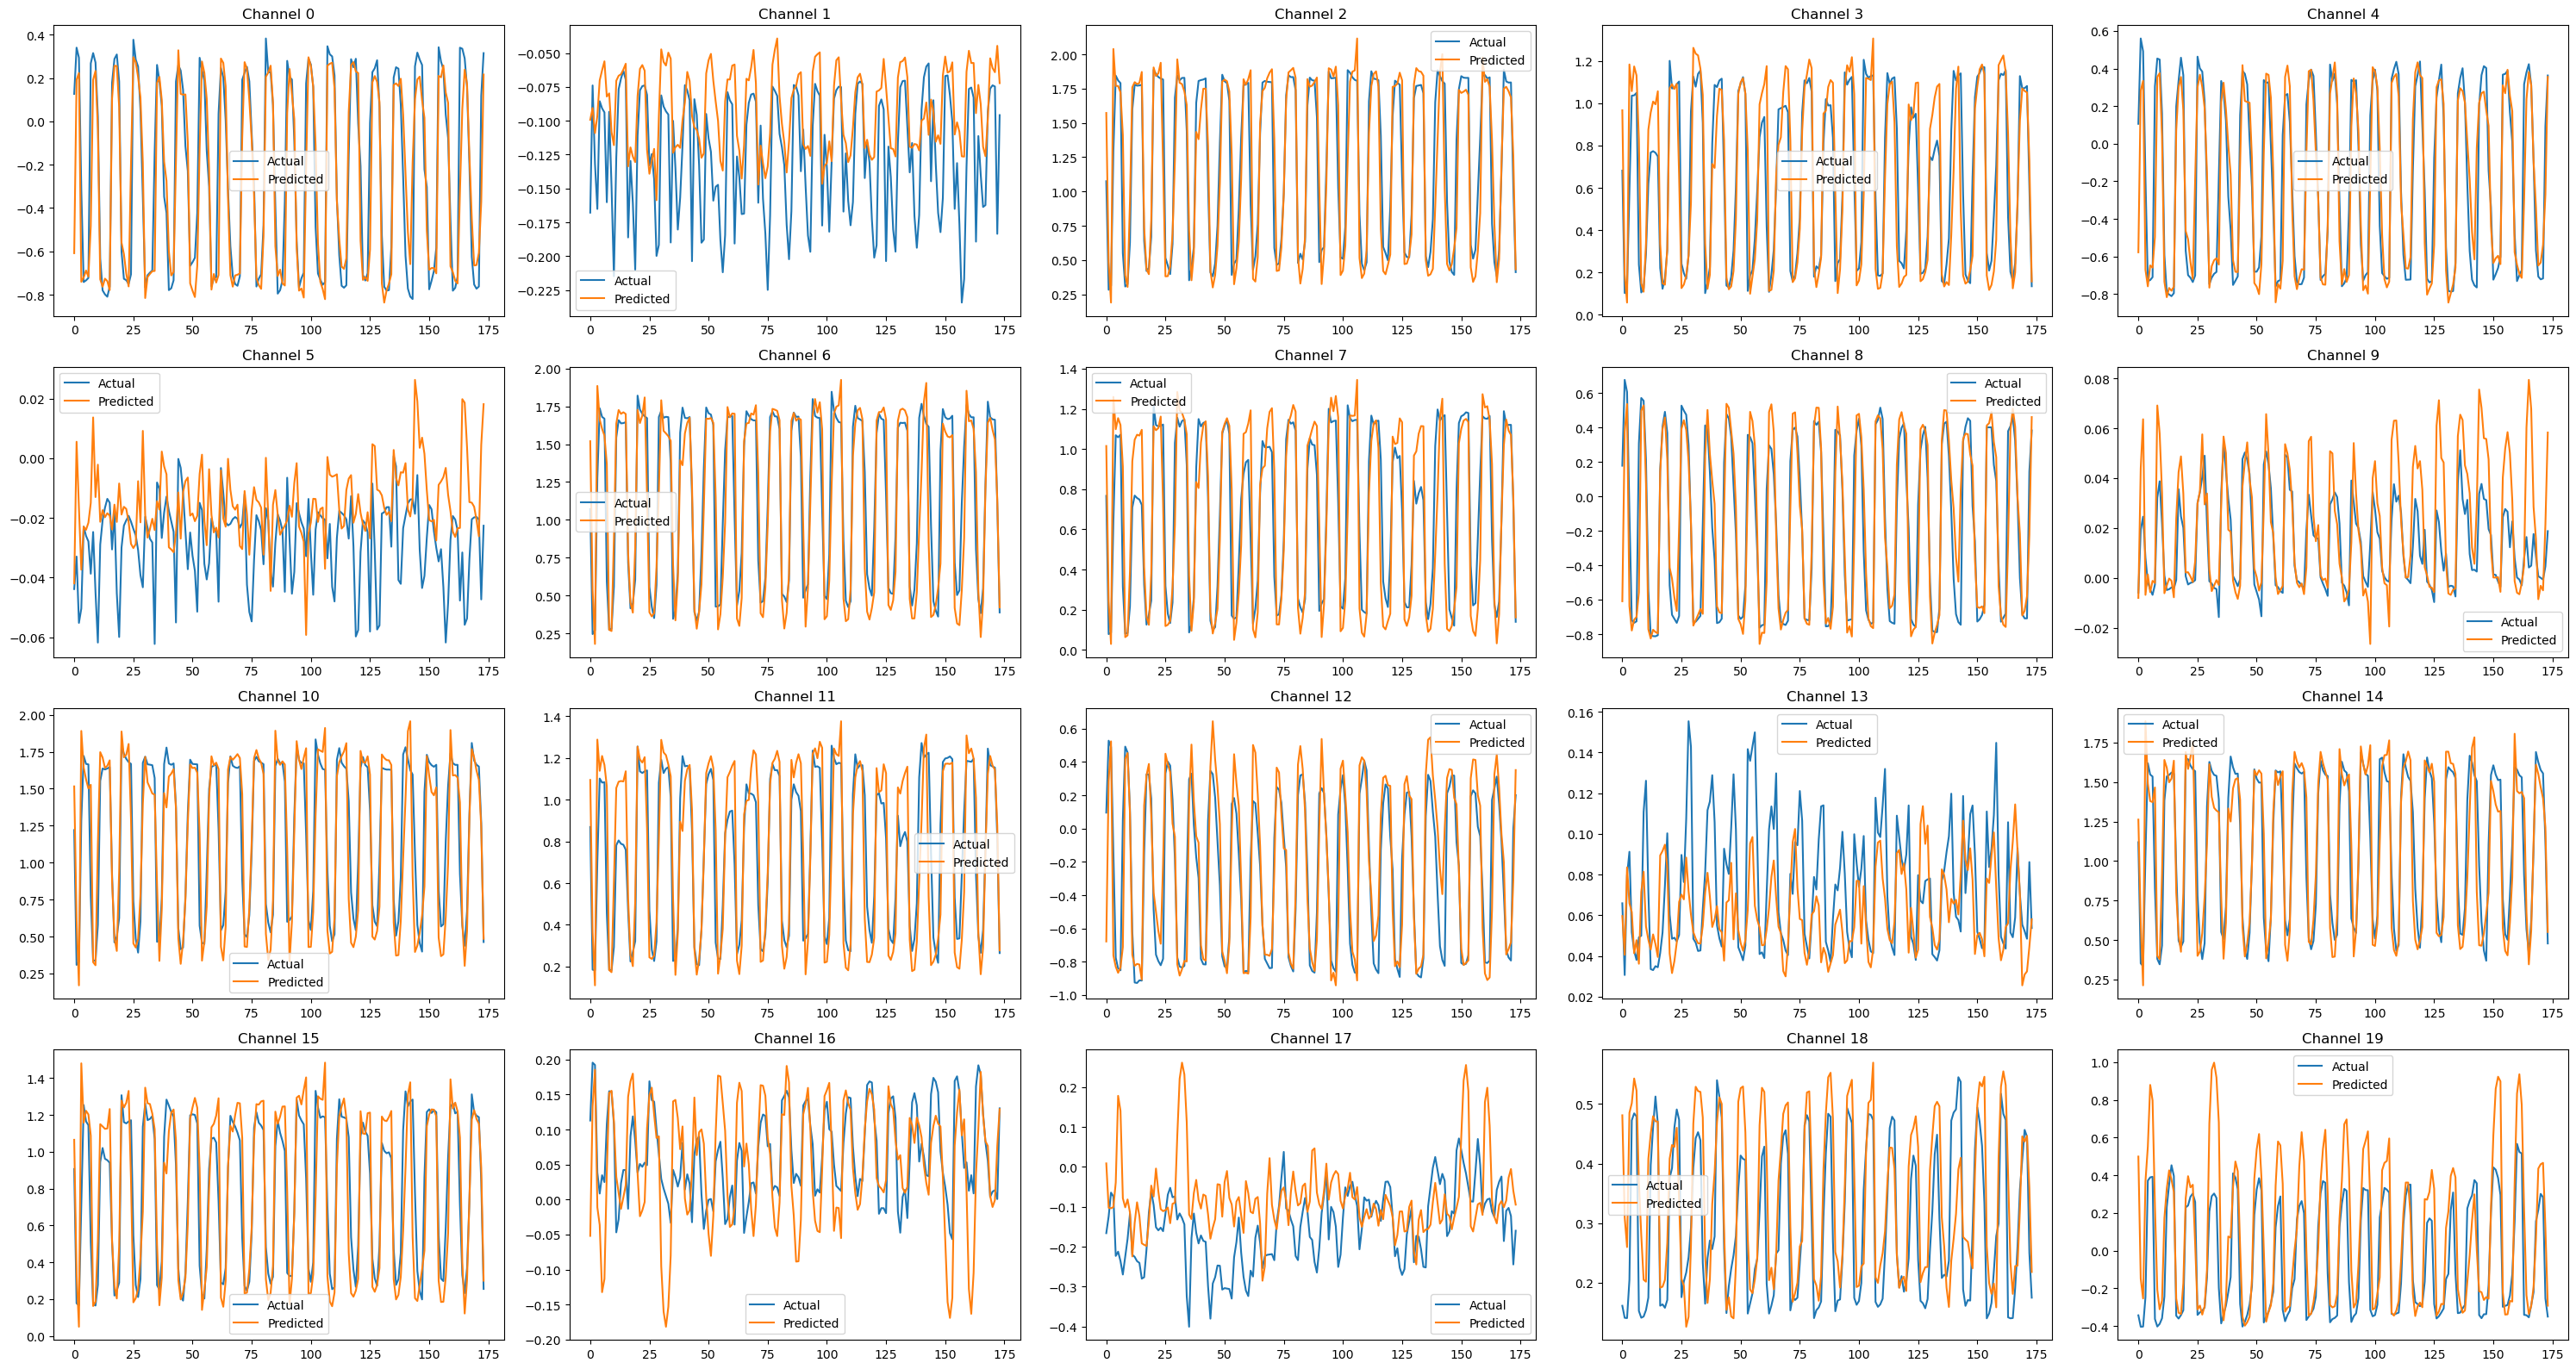

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[:174, i])
    axs[i].plot(y_model_pred[:174, i])
    axs[i].set_title(f"Channel {i}")
    axs[i].legend(["Actual", "Predicted"])

plt.tight_layout()
plt.show()

#### Autoregression

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchAutoRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_dim + output_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x_seq, y_prev=None, teacher_forcing=False):
        batch, seq_len, _ = x_seq.shape
        device = x_seq.device
        outputs = []
        h, c = None, None
        y_t = torch.zeros(batch, self.output_dim, device=device)
        for t in range(seq_len):
            x_t = x_seq[:, t]
            inp = torch.cat([x_t, y_t], dim=-1).unsqueeze(1)
            out_lstm, (h, c) = self.lstm(inp, (h, c) if h is not None else None)
            y_pred = self.mlp(out_lstm[:, 0])
            outputs.append(y_pred.unsqueeze(1))
            y_t = y_prev[:, t] if (teacher_forcing and y_prev is not None) else y_pred
        return torch.cat(outputs, dim=1)


class RiemannAutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_dim=128,
        seq_len=10,
        num_layers=1,
        alpha=1e-5,
        lr=1e-3,
        max_iter=1,
        batch_size=32,
        device="cpu",
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(self, X, y, X_val=None, y_val=None):
        # 1) Riemannian features
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        # Validation transforms
        if X_val is not None and y_val is not None:
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)

        # 2) Autoregressive sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        if X_val is not None and y_val is not None:
            X_seq_val, y_seq_val = prepare_sequences(X_ts_val, y_val, self.seq_len)

        # to tensors
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        y_seq = torch.tensor(y_seq, dtype=torch.float32).to(self.device)
        if X_val is not None and y_val is not None:
            X_seq_val = torch.tensor(X_seq_val, dtype=torch.float32).to(self.device)
            y_seq_val = torch.tensor(y_seq_val, dtype=torch.float32).to(self.device)

        print(X_seq_val.shape)
        print(y_seq_val.shape)

        # dims
        _, seq_len, feat_dim = X_seq.shape
        _, _, out_dim = y_seq.shape

        # 3) Model init
        self.model_ = TorchAutoRegressor(
            input_dim=feat_dim,
            hidden_dim=self.hidden_dim,
            output_dim=out_dim,
            num_layers=self.num_layers,
        ).to(self.device)
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)
        criterion = nn.MSELoss()
        loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_seq, y_seq),
            batch_size=self.batch_size,
            shuffle=True,
        )

        # Training loop
        for epoch in range(1, self.max_iter + 1):

            # train
            self.model_.train()
            total_loss = 0.0

            for xb, yb in loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                out = self.model_(xb, y_prev=yb, teacher_forcing=True)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            # metrics
            if self.verbose and epoch % 10 == 0:
                avg_train_loss = total_loss / len(loader)

                # train corr
                self.model_.eval()
                with torch.no_grad():
                    pred_train = self.model_(X_seq, teacher_forcing=False).cpu().numpy()
                y_train_np = y_seq.cpu().numpy()
                train_corrs = [
                    corrcoef(pred_train[:, :, i].ravel(), y_train_np[:, :, i].ravel())
                    for i in range(out_dim)
                ]
                train_mean_corr = np.nanmean(train_corrs)
                msg = f"Epoch {epoch}/{self.max_iter} Train Loss: {avg_train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                # val metrics
                if X_val is not None and y_val is not None:
                    with torch.no_grad():
                        pred_val = (
                            self.model_(X_seq_val, teacher_forcing=False).cpu().numpy()
                        )
                    y_val_np = y_seq_val.cpu().numpy()
                    val_loss = criterion(
                        torch.tensor(pred_val), torch.tensor(y_val_np)
                    ).item()
                    val_corrs = [
                        corrcoef(pred_val[:, :, i].ravel(), y_val_np[:, :, i].ravel())
                        for i in range(out_dim)
                    ]
                    val_mean_corr = np.nanmean(val_corrs)
                    msg += f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                print(msg)

                # validation
                # if self.verbose:
                #     validation(self, X_val, y_val, verbose=False)

        return self

    def validate(self, X, y):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_seq = prepare_single_sequence(X_ts, self.seq_len)
        X_seq = torch.tensor(X_seq, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            out_seq = self.model_(X_seq, teacher_forcing=False)
        return out_seq.cpu().numpy()


model = RiemannAutoRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=10,
    num_layers=1,
    alpha=1e-5,
    lr=1e-3,
    max_iter=50,
    batch_size=64,
    device="cuda",
    verbose=True,
)
model.fit(X_train, y_train, X_test, y_test)

torch.Size([6926, 10, 36])
torch.Size([6926, 10, 20])
Epoch 10/50 Train Loss: 0.0071, Train Corr: 0.899, Val Loss: 0.0215, Val Corr: 0.872
Epoch 20/50 Train Loss: 0.0063, Train Corr: 0.904, Val Loss: 0.0197, Val Corr: 0.877
Epoch 30/50 Train Loss: 0.0060, Train Corr: 0.909, Val Loss: 0.0186, Val Corr: 0.882
Epoch 40/50 Train Loss: 0.0058, Train Corr: 0.908, Val Loss: 0.0202, Val Corr: 0.879
Epoch 50/50 Train Loss: 0.0057, Train Corr: 0.912, Val Loss: 0.0192, Val Corr: 0.882


RiemannAutoRegressor(batch_size=64, device='cuda', max_iter=50, verbose=True)

In [9]:
y_pred = validation_streaming(model, X_test, y_test, verbose=True)

Channel-wise correlations: ['0.936', '0.845', '0.954', '0.959', '0.950', '0.866', '0.949', '0.952', '0.950', '0.937', '0.949', '0.949', '0.945', '0.923', '0.952', '0.957', '0.946', '0.966', '0.945', '0.940']
Mean correlation:         0.939
Channel-wise R2 scores:   ['0.873', '0.620', '0.903', '0.913', '0.897', '0.740', '0.887', '0.895', '0.896', '0.836', '0.887', '0.890', '0.886', '0.848', '0.890', '0.907', '0.890', '0.931', '0.886', '0.880']
Mean R2 score:            0.868
model:
  Mean correlation: 0.939 ± 0.029
  Individual correlations: ['0.936', '0.845', '0.954', '0.959', '0.950', '0.866', '0.949', '0.952', '0.950', '0.937', '0.949', '0.949', '0.945', '0.923', '0.952', '0.957', '0.946', '0.966', '0.945', '0.940']

  Mean R2: 0.868 ± 0.068
  Individual R2: ['0.873', '0.620', '0.903', '0.913', '0.897', '0.740', '0.887', '0.895', '0.896', '0.836', '0.887', '0.890', '0.886', '0.848', '0.890', '0.907', '0.890', '0.931', '0.886', '0.880']



NameError: name 'y_pred' is not defined

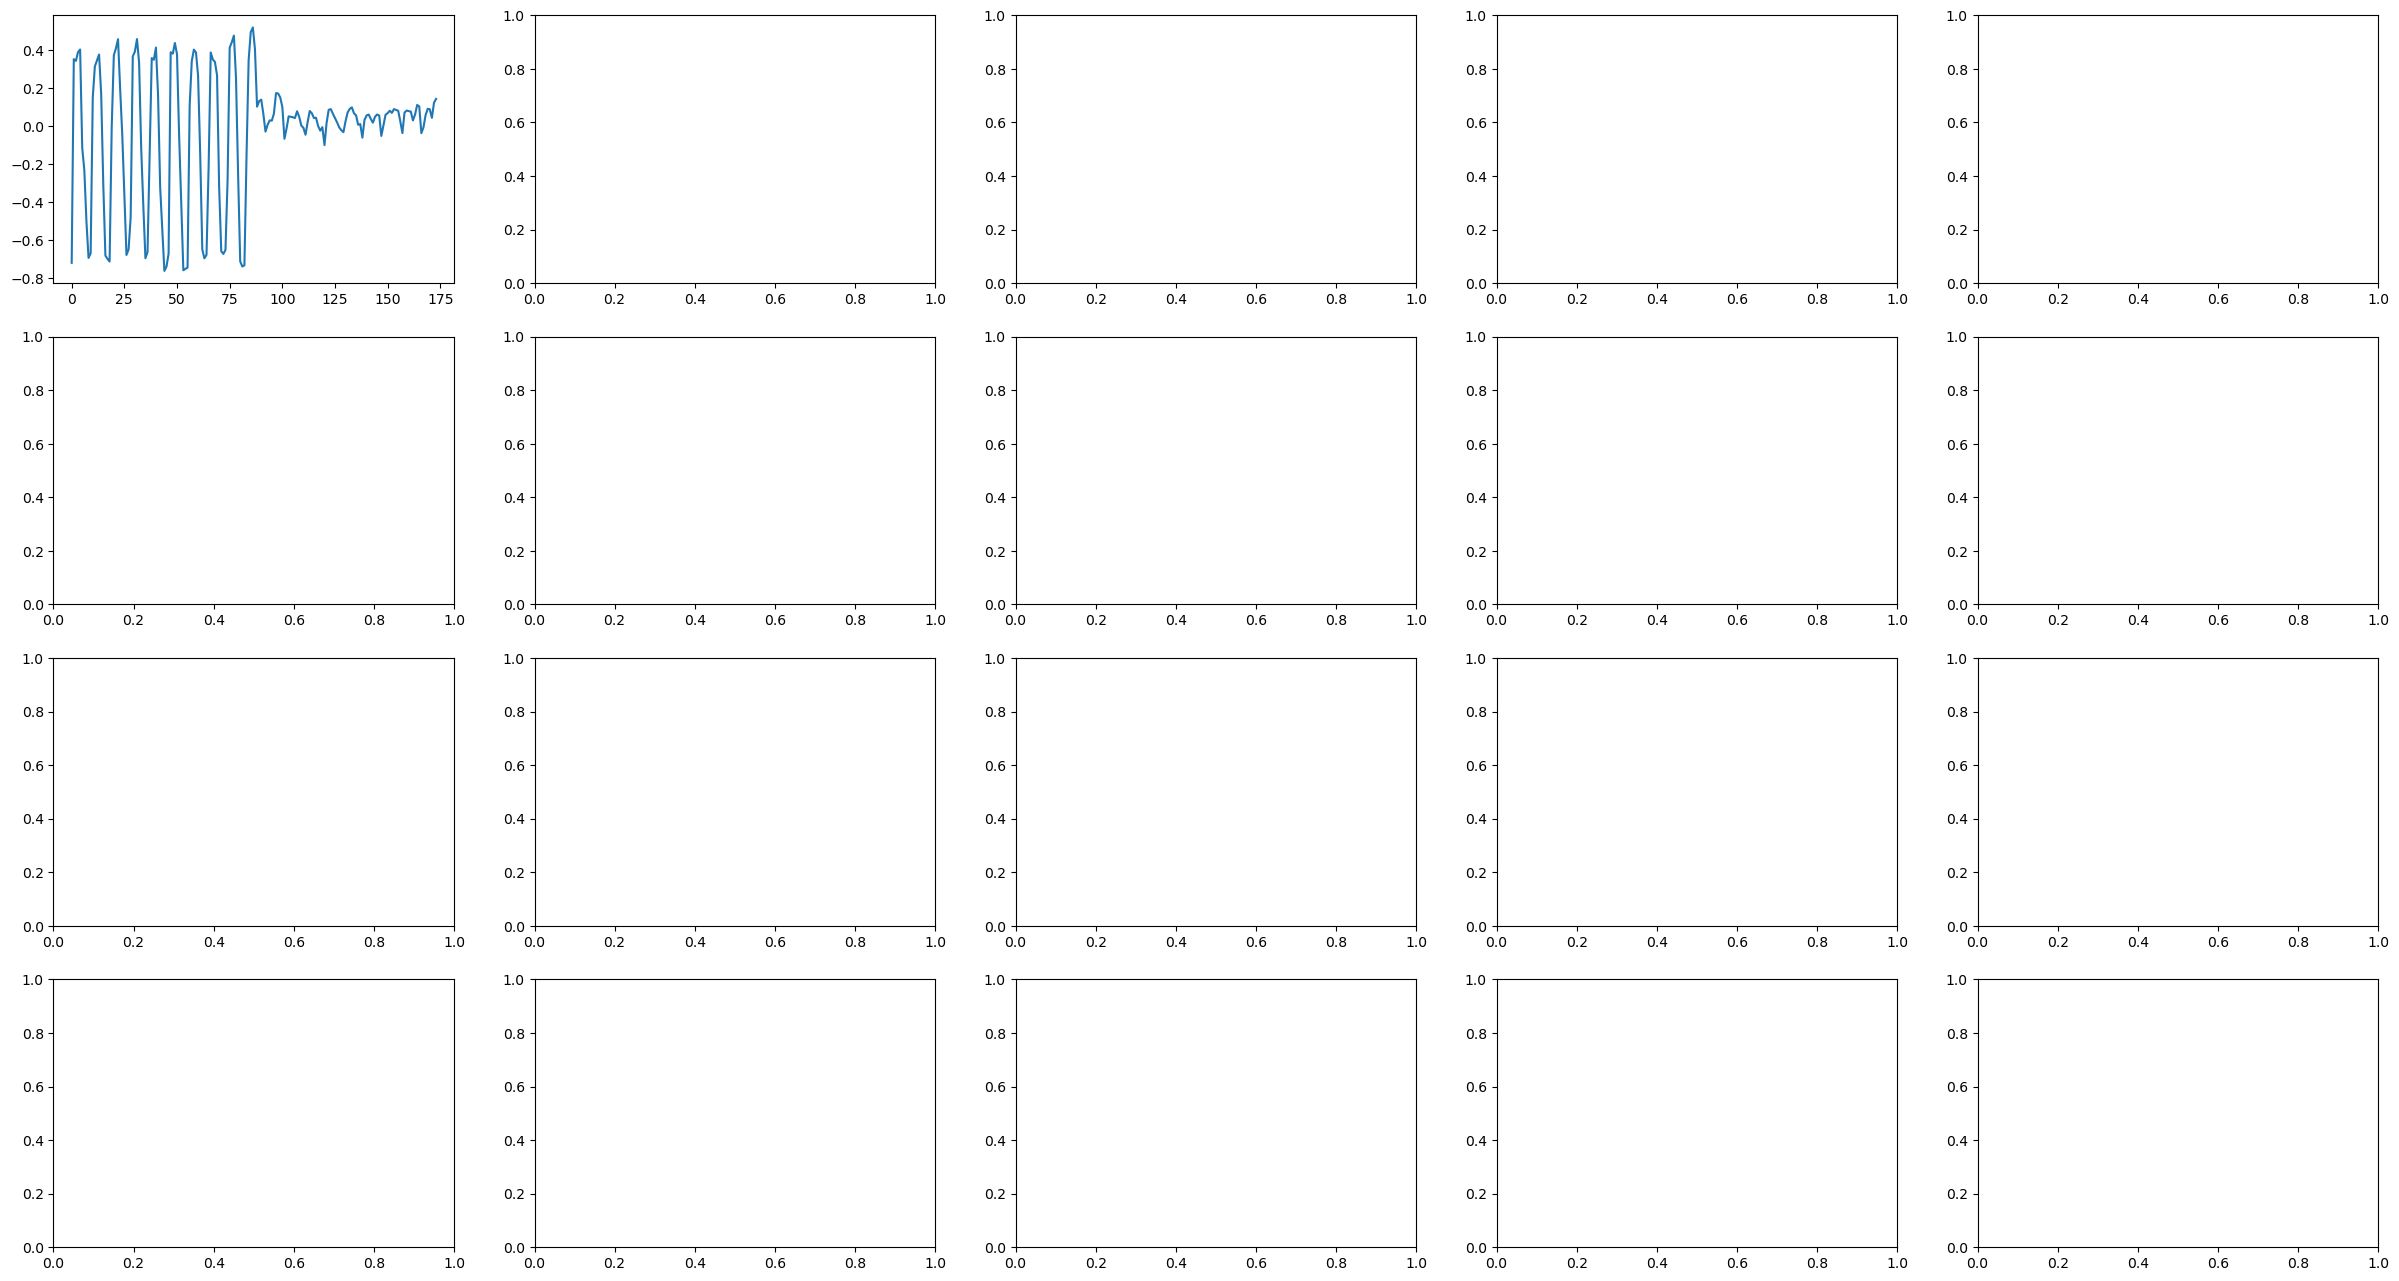

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[:174, i])
    axs[i].plot(y_pred[:174, i])
    axs[i].set_title(f"Channel {i}")
    axs[i].legend(["Actual", "Predicted"])

plt.tight_layout()
plt.show()

In [7]:
y_pred = validation(model, X_test, y_test, verbose=True)

100%|██████████| 6936/6936 [1:27:27<00:00,  1.32it/s]

Channel-wise correlations: ['0.932', '0.774', '0.948', '0.952', '0.941', '0.738', '0.943', '0.947', '0.945', '0.788', '0.943', '0.952', '0.932', '0.793', '0.925', '0.942', '0.915', '0.834', '0.888', '0.914']
Mean correlation:         0.897
Channel-wise R2 scores:   ['0.867', '0.598', '0.897', '0.906', '0.868', '0.520', '0.883', '0.894', '0.887', '0.594', '0.887', '0.905', '0.868', '0.595', '0.852', '0.885', '0.832', '0.583', '0.788', '0.828']
Mean R2 score:            0.797
model:
  Mean correlation: 0.897 ± 0.068
  Individual correlations: ['0.932', '0.774', '0.948', '0.952', '0.941', '0.738', '0.943', '0.947', '0.945', '0.788', '0.943', '0.952', '0.932', '0.793', '0.925', '0.942', '0.915', '0.834', '0.888', '0.914']

  Mean R2: 0.797 ± 0.130
  Individual R2: ['0.867', '0.598', '0.897', '0.906', '0.868', '0.520', '0.883', '0.894', '0.887', '0.594', '0.887', '0.905', '0.868', '0.595', '0.852', '0.885', '0.832', '0.583', '0.788', '0.828']



Channel-wise correlations: ['0.932', '0.774', '0.948', '0.952', '0.941', '0.738', '0.943', '0.947', '0.945', '0.788', '0.943', '0.952', '0.932', '0.793', '0.925', '0.942', '0.915', '0.834', '0.888', '0.914']
Mean correlation:         0.897
Channel-wise R2 scores:   ['0.867', '0.598', '0.897', '0.906', '0.868', '0.520', '0.883', '0.894', '0.887', '0.594', '0.887', '0.905', '0.868', '0.595', '0.852', '0.885', '0.832', '0.583', '0.788', '0.828']
Mean R2 score:            0.797
model:
  Mean correlation: 0.897 ± 0.068
  Individual correlations: ['0.932', '0.774', '0.948', '0.952', '0.941', '0.738', '0.943', '0.947', '0.945', '0.788', '0.943', '0.952', '0.932', '0.793', '0.925', '0.942', '0.915', '0.834', '0.888', '0.914']

  Mean R2: 0.797 ± 0.130
  Individual R2: ['0.867', '0.598', '0.897', '0.906', '0.868', '0.520', '0.883', '0.894', '0.887', '0.594', '0.887', '0.905', '0.868', '0.595', '0.852', '0.885', '0.832', '0.583', '0.788', '0.828']